# OPTICS Clustering
# Checking the Python Environment

This is to ensure that the correct Python environment is set up correctly and used

In [1]:
import sys
import IPython

# Change path to append here
sys.path.append(r'C:\Users\hp\Downloads\Machine Learning Assignment')

print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("Kernel:", IPython.get_ipython().kernel)
print("Sys paths:", sys.path)

Python executable: C:\Users\hp\Downloads\Machine Learning Assignment\ml-venv\Scripts\python.exe
Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Kernel: <ipykernel.ipkernel.IPythonKernel object at 0x000001945AEEF7D0>
Sys paths: ['C:\\Users\\hp\\Downloads\\Machine Learning Assignment', 'C:\\Users\\hp\\anaconda3\\python311.zip', 'C:\\Users\\hp\\anaconda3\\DLLs', 'C:\\Users\\hp\\anaconda3\\Lib', 'C:\\Users\\hp\\anaconda3', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment\\ml-venv', '', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment\\ml-venv\\Lib\\site-packages', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment\\ml-venv\\Lib\\site-packages\\win32', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment\\ml-venv\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment\\ml-venv\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\hp\\Downloads\\Machine Learning Assignment']


# Importing Libraries

This is to ensure that the necessary libraries are imported and used

In [2]:
# For DataFrame
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For clustering models
from sklearn.cluster import OPTICS

# For results evaluation
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Loading the Dataset

Following shows the raw dataset that is loaded into the notebook

In [3]:
df_scaled = pd.read_csv(r'../raw_data/customer_standard_scaled.csv', index_col = 'CUST_ID')

df_pca = pd.read_csv(r'../raw_data/customer_pca_5.csv', index_col = 'CUST_ID')
df_tsne = pd.read_csv(r'../raw_data/customer_tsne_3.csv', index_col = 'CUST_ID')
df_umap = pd.read_csv(r'../raw_data/customer_umap_3.csv', index_col = 'CUST_ID')

# 1.0 Model Training

Four datasets will be experimented with the OPTICS clustering algorithm:
1. Scaled dataset
2. PCA dataset
3. t-SNE dataset
4. UMAP dataset

In [4]:
import matplotlib.patches as mpatches

# Function to perform OPTICS clustering and plot reachability distances using Seaborn
def optics_clustering_with_reachability(df, min_samples = 5, xi = 0.05, plot = True, show_number_of_clusters = True):
    # Fit the OPTICS model
    optics_model = OPTICS(min_samples = min_samples, xi = xi)
    optics_model.fit(df)
    
    if not plot:
        return optics_model

    # Extract reachability distances and cluster labels
    reachability = optics_model.reachability_[optics_model.ordering_]
    labels = optics_model.labels_[optics_model.ordering_]

    # Create a color map for the clusters
    unique_labels = np.unique(labels)
    palette = sns.color_palette('viridis', len(unique_labels))
    color_map = {label: color for label, color in zip(unique_labels, palette)}

    # Plot the reachability distances with colors corresponding to the cluster labels
    plt.figure(figsize=(12, 6))
    for i in range(len(reachability) - 1):
        plt.plot([i, i + 1], [reachability[i], reachability[i + 1]], color= color_map[labels[i]])
        plt.fill_between([i, i + 1], [reachability[i], reachability[i + 1]], color= color_map[labels[i]], alpha=0.3)

    if show_number_of_clusters:
        plt.legend([f'Total Clusters: {len(unique_labels)}'], loc='upper right')
    else:
        handles = [mpatches.Patch(color=color_map[label], label=f'Cluster {label}') for label in unique_labels]
        plt.legend(handles=handles, loc='upper right', title = 'Clusters')
    
    plt.title(f'OPTICS Clustering with min_samples = {min_samples} and xi = {xi}')
    plt.xlabel('Order')
    plt.ylabel('Reachability Distance')
    plt.show()

    return optics_model

def visualise_optics_clusters(df, cluster_labels, axes, s):
    # Plot using Seaborn
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot using Seaborn
    sc = ax.scatter(xs = df.iloc[:, 0], ys = df.iloc[:, 1], zs = df.iloc[:, 2], c = cluster_labels, cmap = 'viridis', s = s)

    # Create a legend
    plt.colorbar(sc).set_label('Cluster')

    # Set labels
    ax.set_title('3D Scatter Plot')
    ax.set_xlabel(f'{axes} 1')
    ax.set_ylabel(f'{axes} 2')
    ax.set_zlabel(f'{axes} 3')
    plt.show()

def plot_optics_metrics(df, optics_models, x_list, xlabel = 'min_samples'):
    ch_scores = []
    sil_scores = []
    db_scores = []

    for model in optics_models:
        # Compute metrics
        if len(np.unique(model.labels_)) > 1:
            ch_scores.append(calinski_harabasz_score(df, model.labels_))
            sil_scores.append(silhouette_score(df, model.labels_))
            db_scores.append(davies_bouldin_score(df, model.labels_))
        else:
            ch_scores.append(0)
            sil_scores.append(-1)
            db_scores.append(0)

    # Plot the metrics in subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].plot(x_list, ch_scores, label='Calinski-Harabasz Index', marker='o')
    axes[0].set_title('Calinski-Harabasz Index')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Score')

    axes[1].plot(x_list, sil_scores, label='Silhouette Score', marker='o')
    axes[1].set_title('Silhouette Score')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Score')

    axes[2].plot(x_list, db_scores, label='Davies-Bouldin Index', marker='o')
    axes[2].set_title('Davies-Bouldin Index')
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel('Score')

    plt.tight_layout()
    plt.show()

## 1.1 Scaled Dataset

Here we will try initially with different sample to see the outcome of the reachability plot

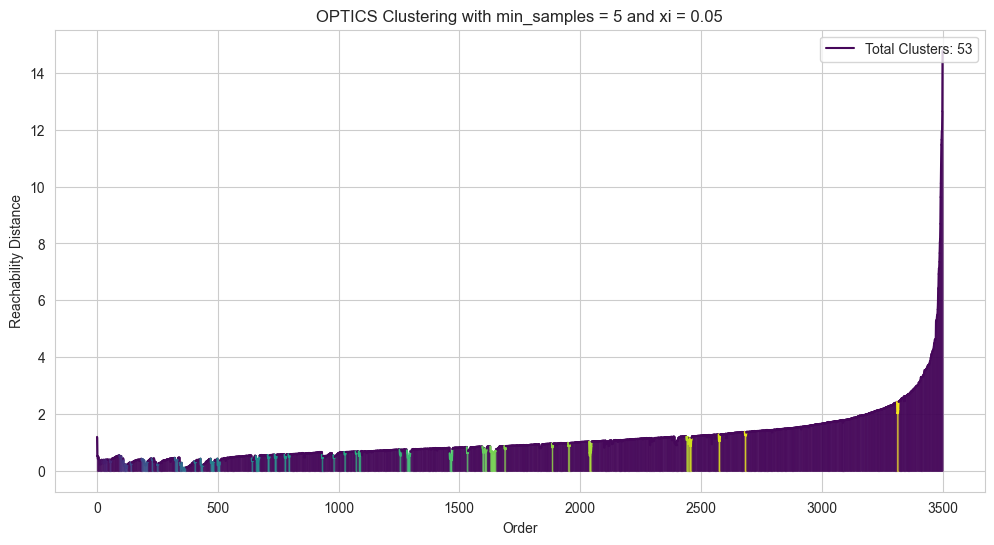

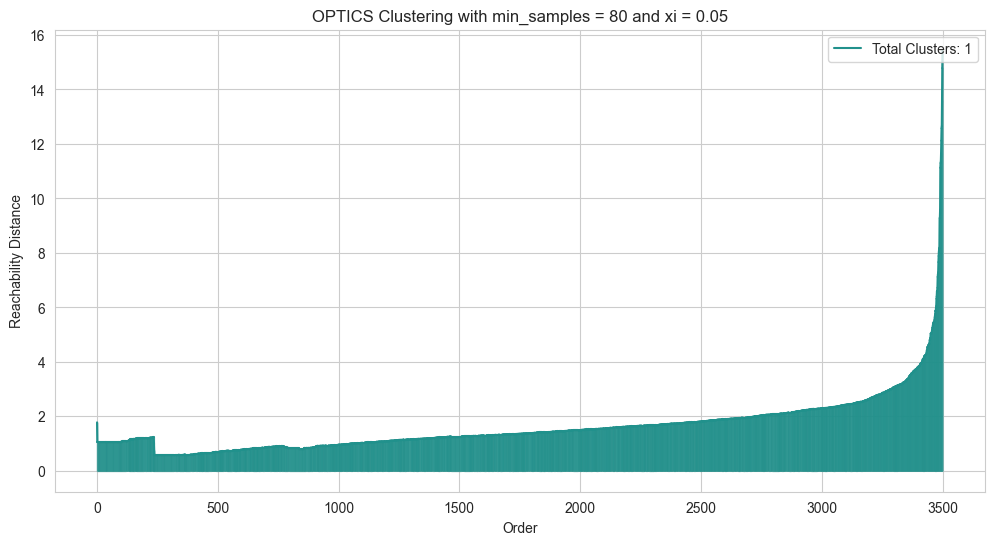

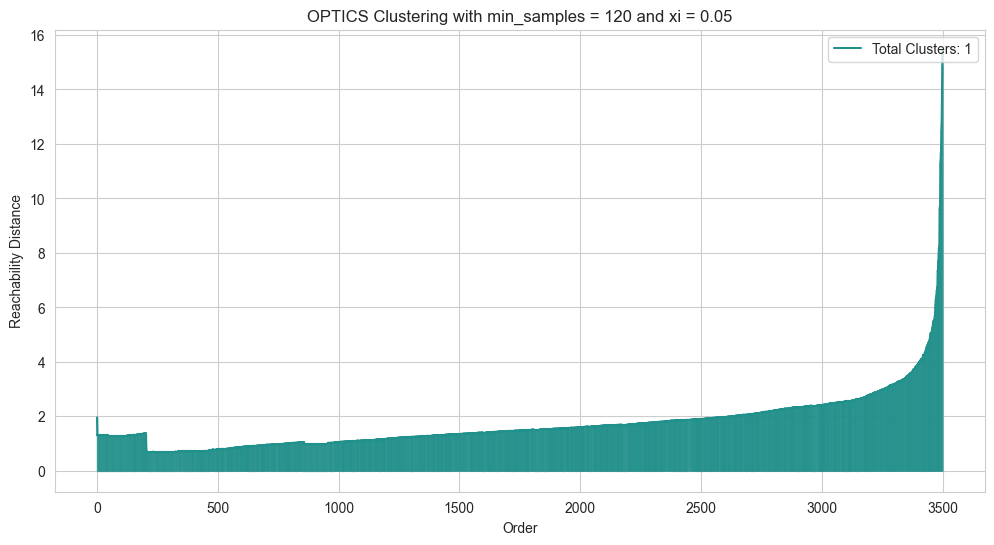

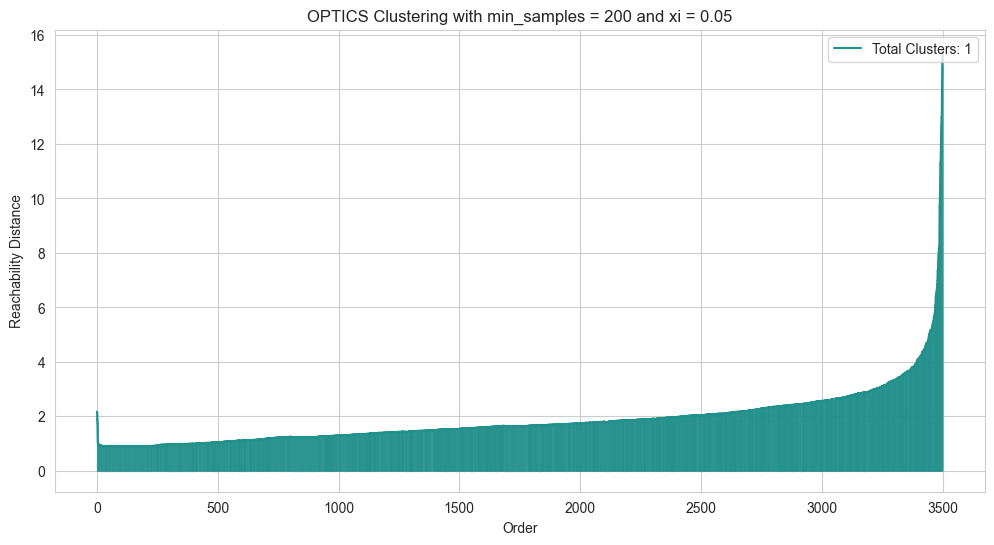

In [5]:
scaled_sample_sizes = [5, 80, 120, 200]
scaled_optics = [optics_clustering_with_reachability(df_scaled, min_samples = sample) for sample in scaled_sample_sizes]

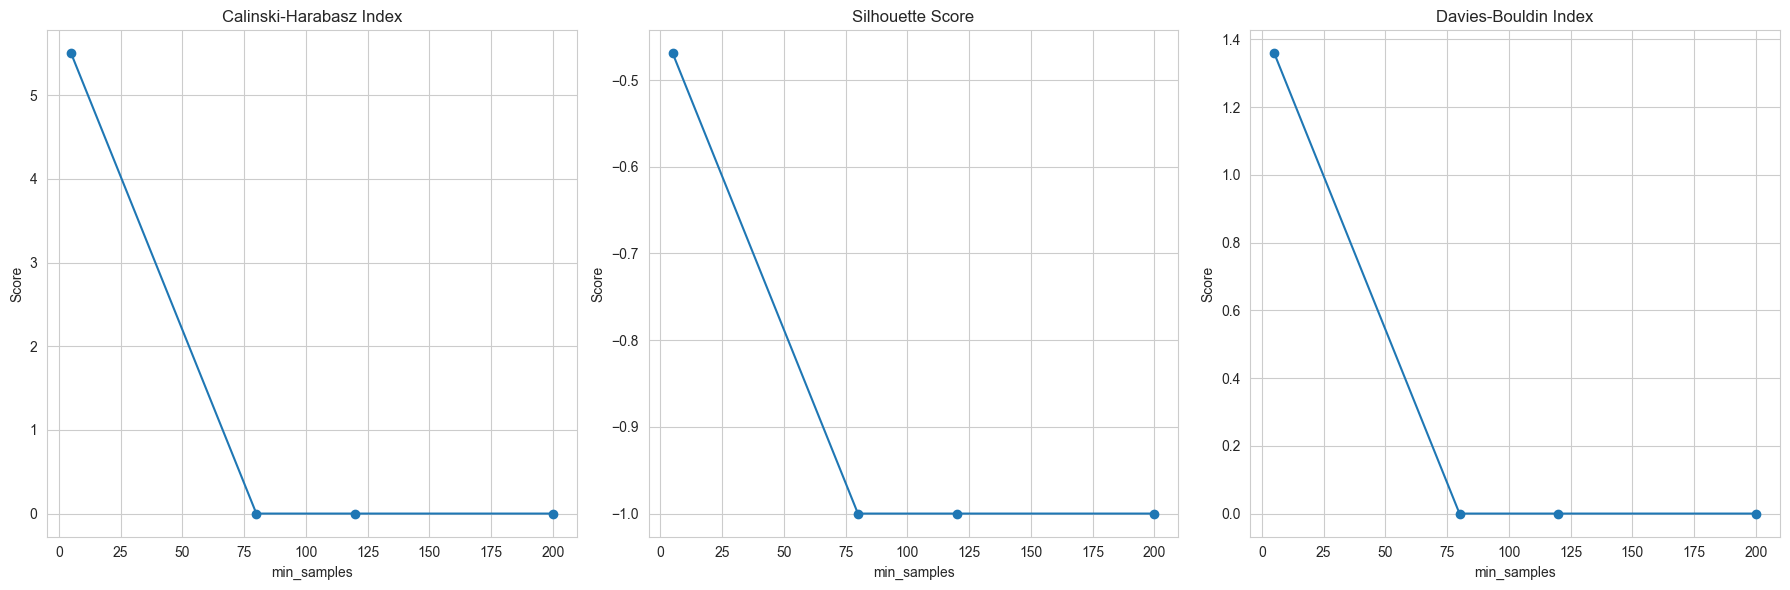

In [6]:
plot_optics_metrics(df_scaled, scaled_optics, scaled_sample_sizes)

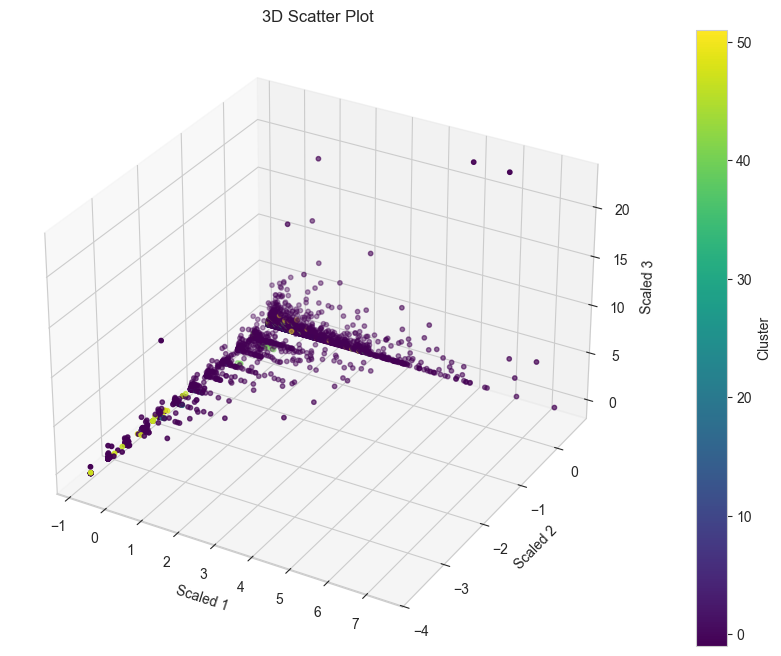

In [7]:
visualise_optics_clusters(df_scaled, scaled_optics[0].labels_, 'Scaled', s = 10)

## 1.2 PCA Dataset

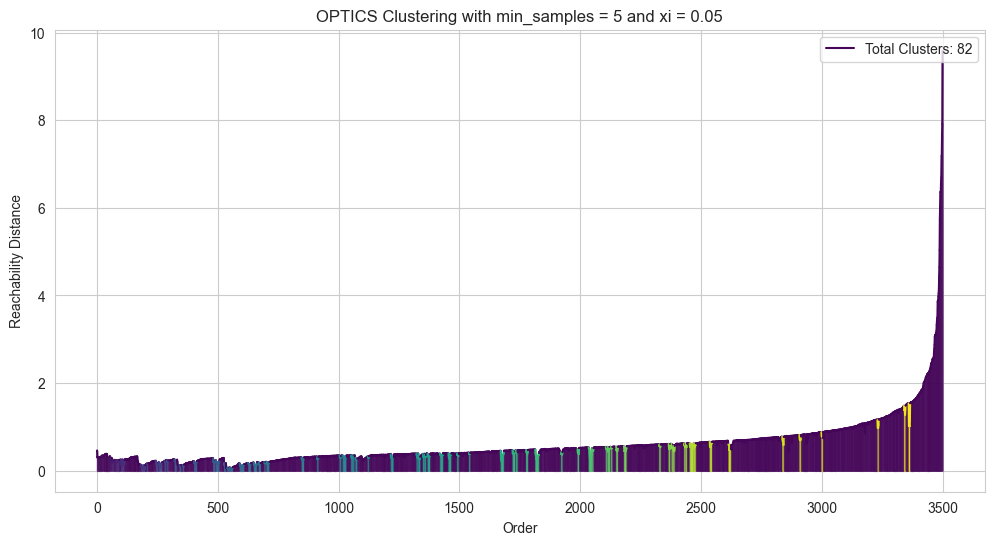

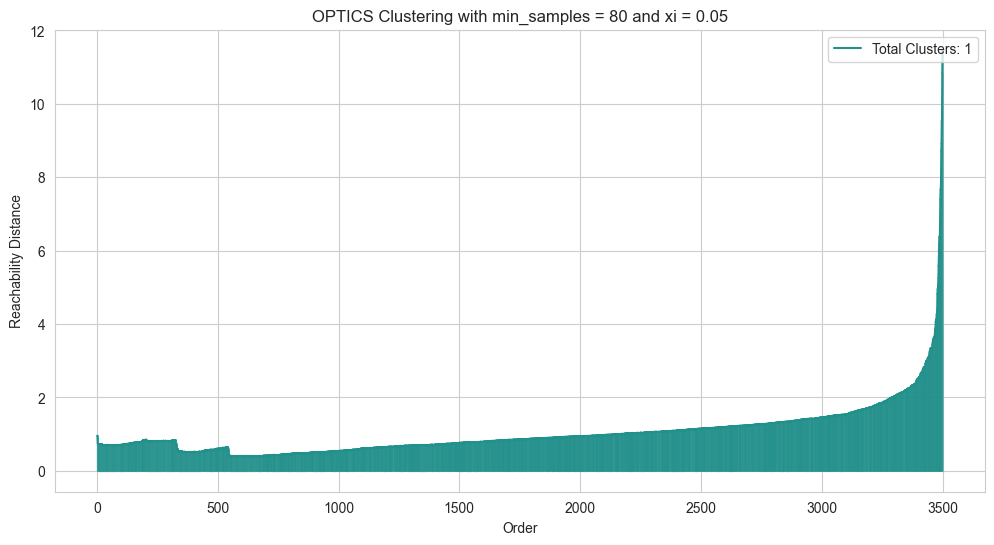

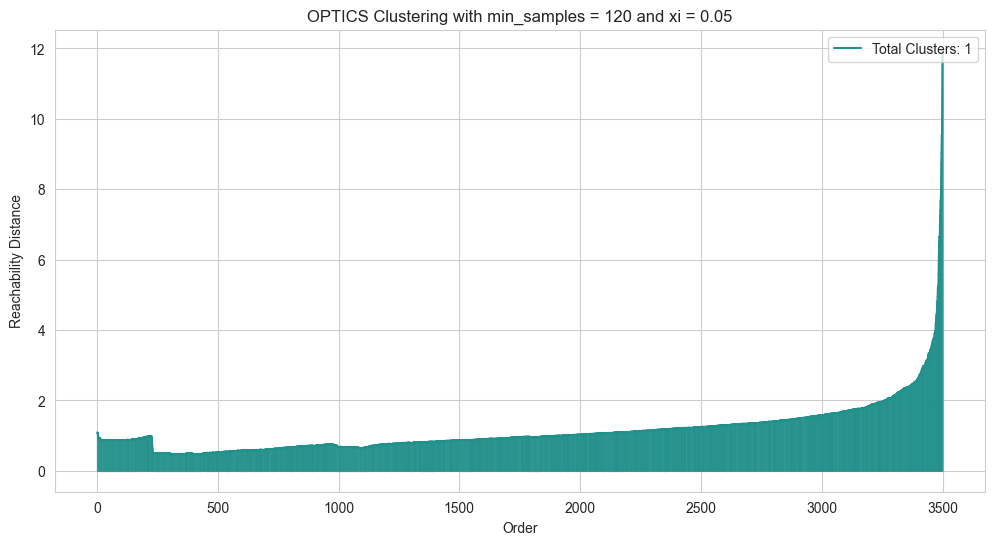

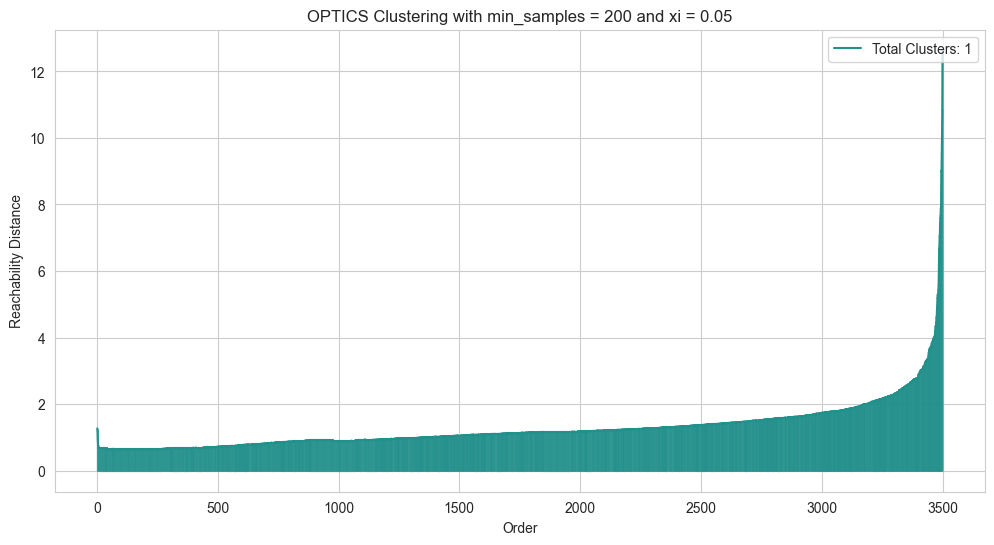

In [8]:
pca_sample_sizes = [5, 80, 120, 200]
pca_optics = [optics_clustering_with_reachability(df_pca, min_samples = sample) for sample in pca_sample_sizes]

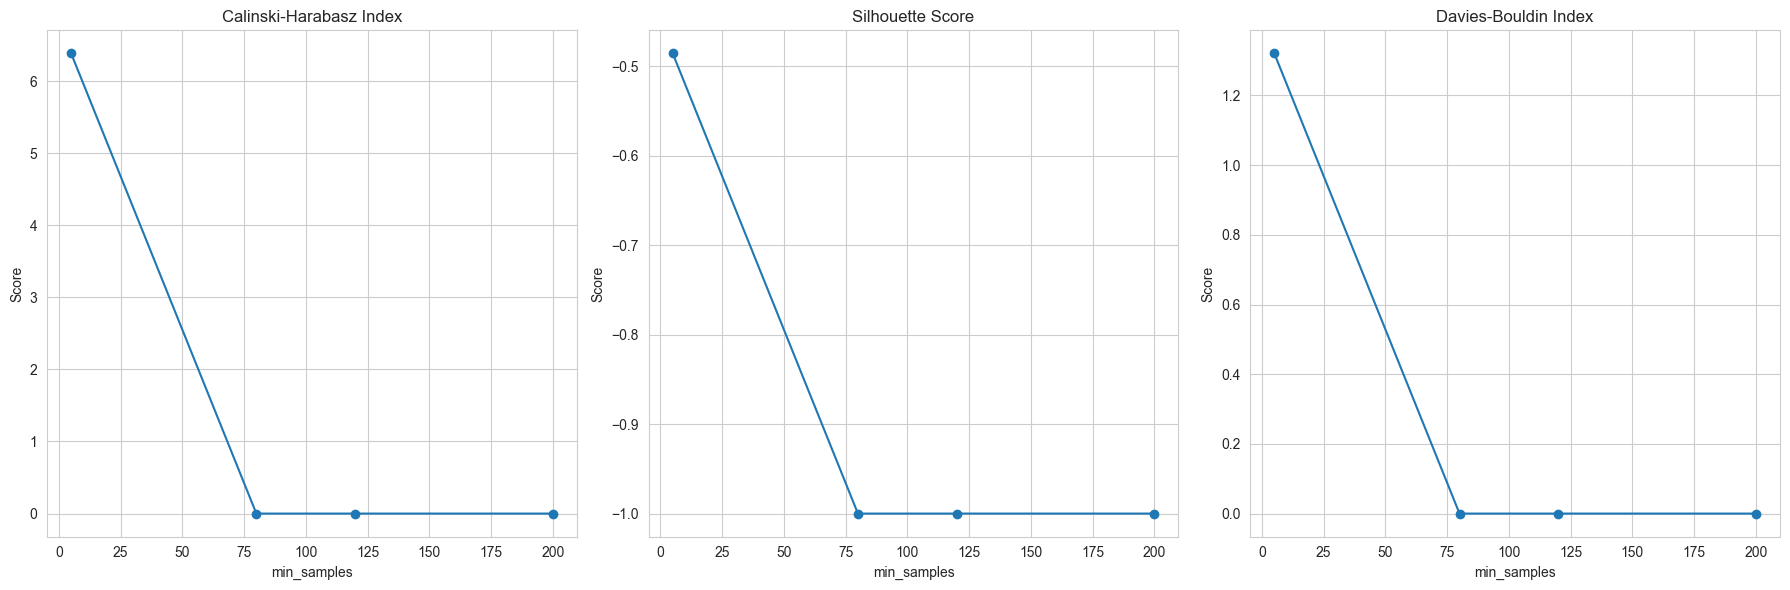

In [9]:
plot_optics_metrics(df_pca, pca_optics, pca_sample_sizes)

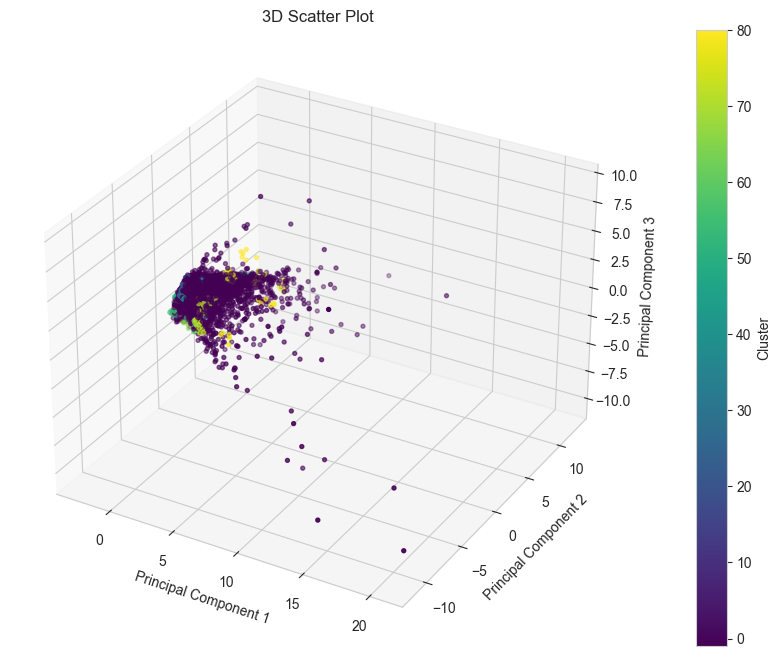

In [10]:
visualise_optics_clusters(df_pca, pca_optics[0].labels_, 'Principal Component', s = 8)

## 1.3 t-SNE Dataset

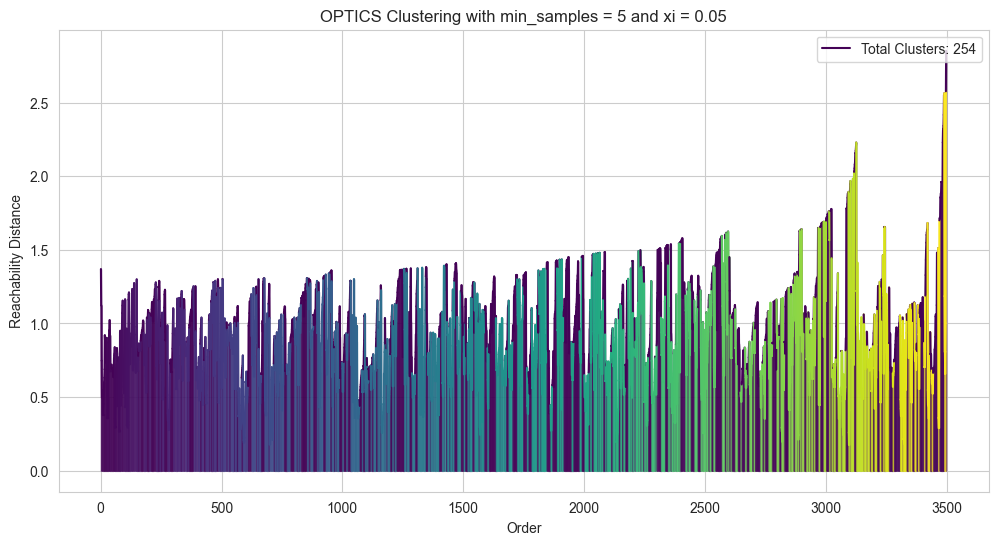

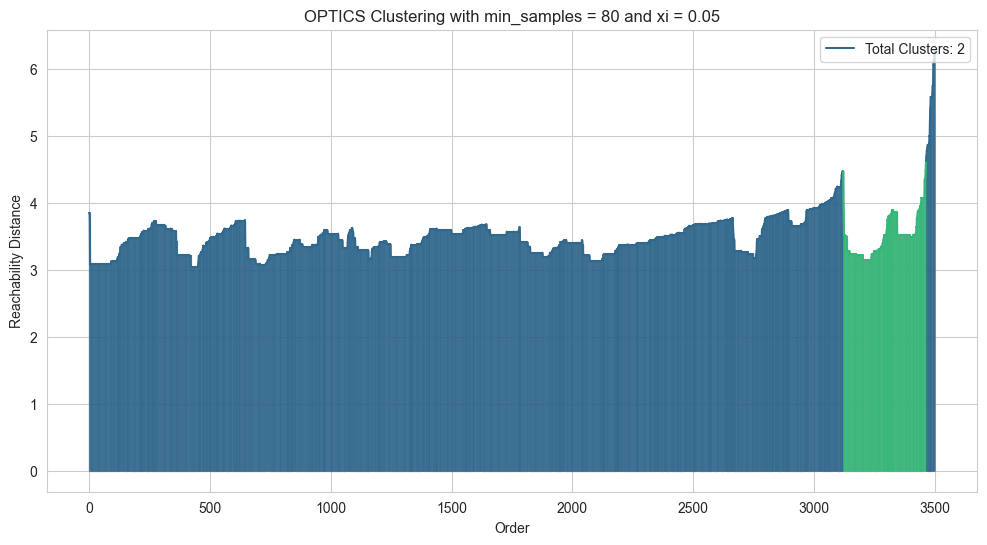

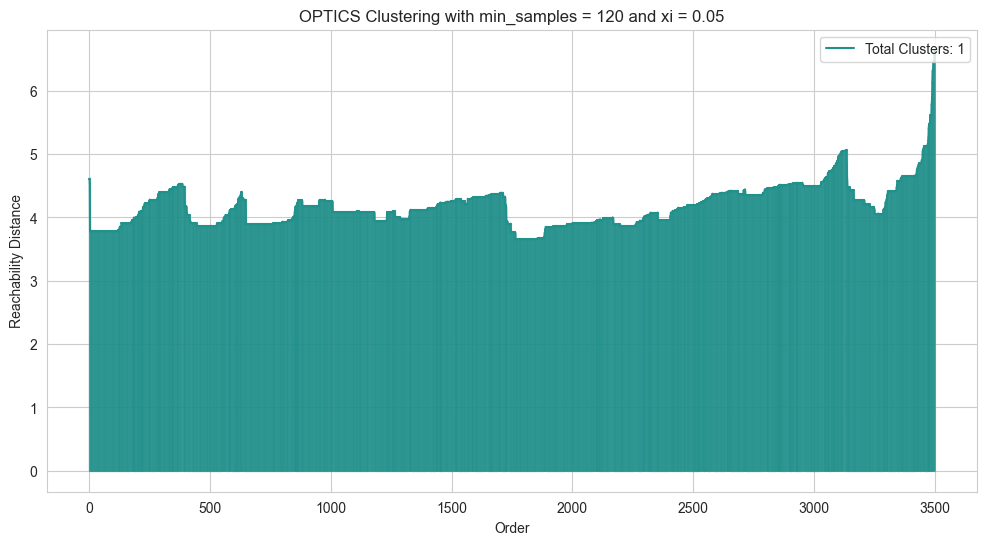

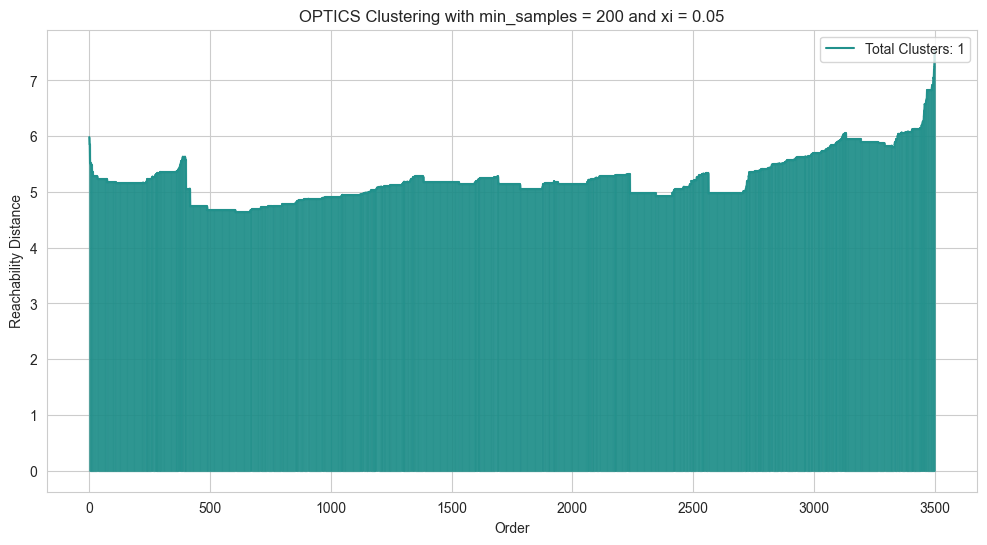

In [11]:
tsne_sample_sizes = [5, 80, 120, 200]
tsne_optics = [optics_clustering_with_reachability(df_tsne, min_samples = sample) for sample in tsne_sample_sizes]

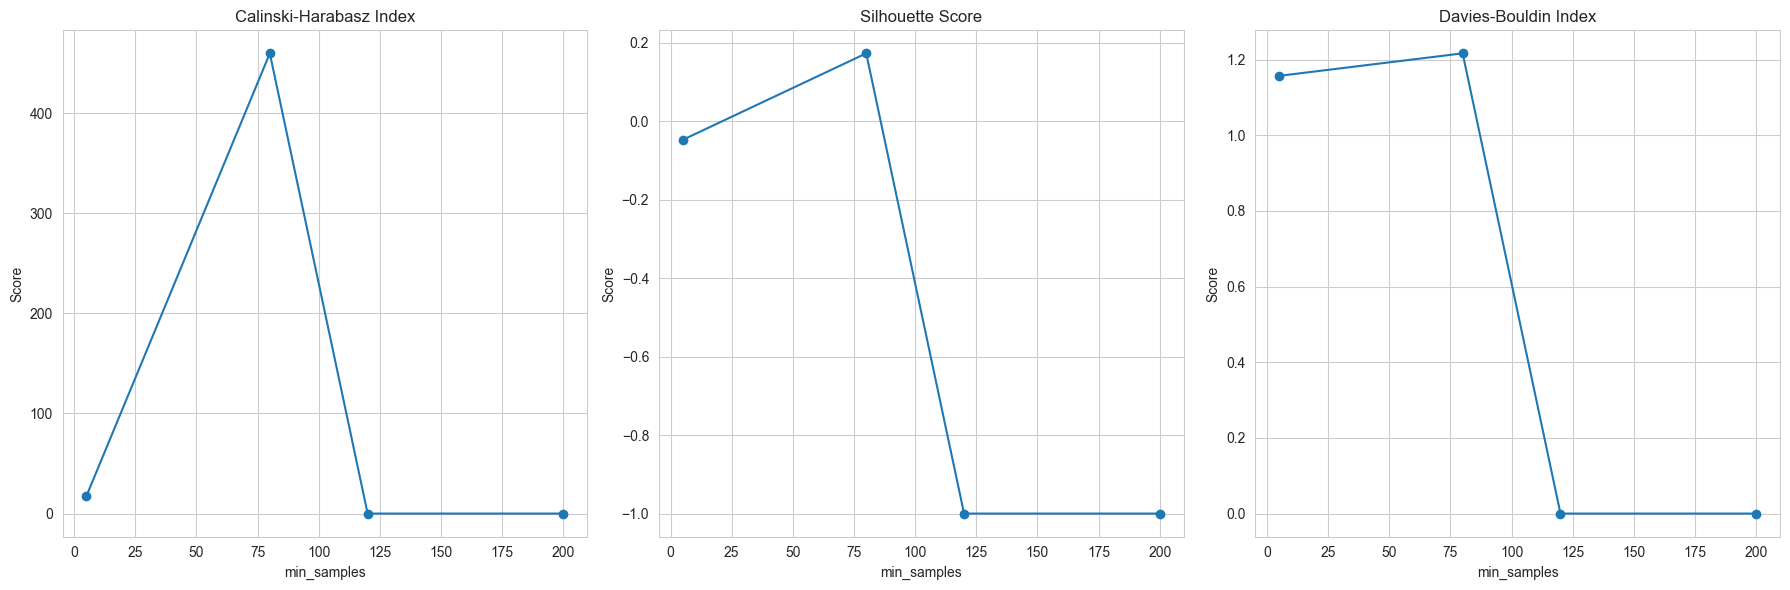

In [12]:
plot_optics_metrics(df_tsne, tsne_optics, tsne_sample_sizes)

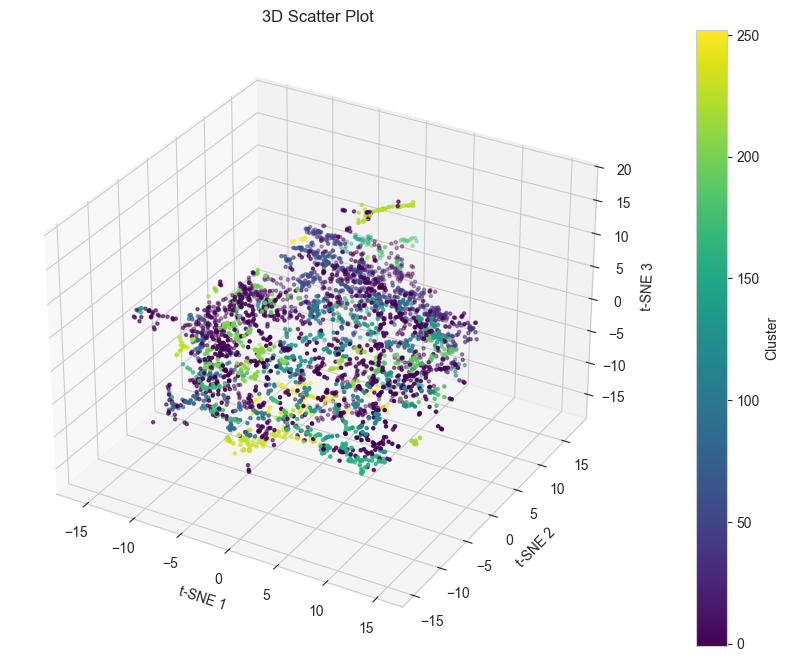

In [13]:
visualise_optics_clusters(df_tsne, tsne_optics[0].labels_, 't-SNE', s = 5)

# 1.4 UMAP Dataset

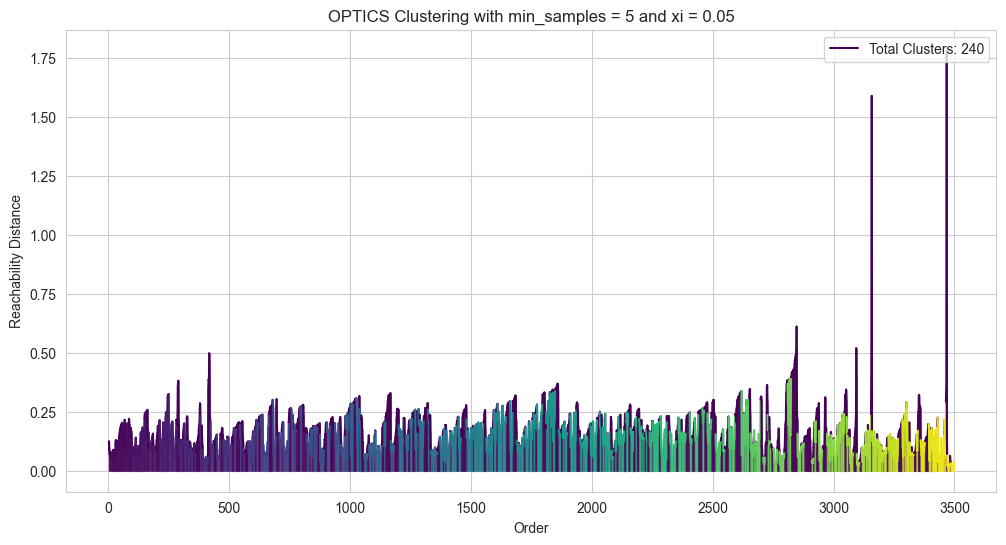

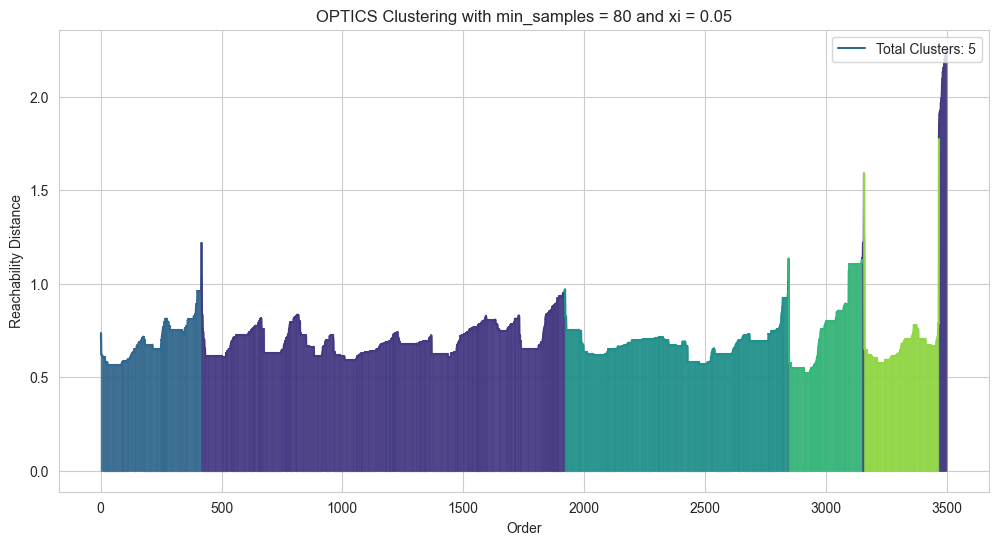

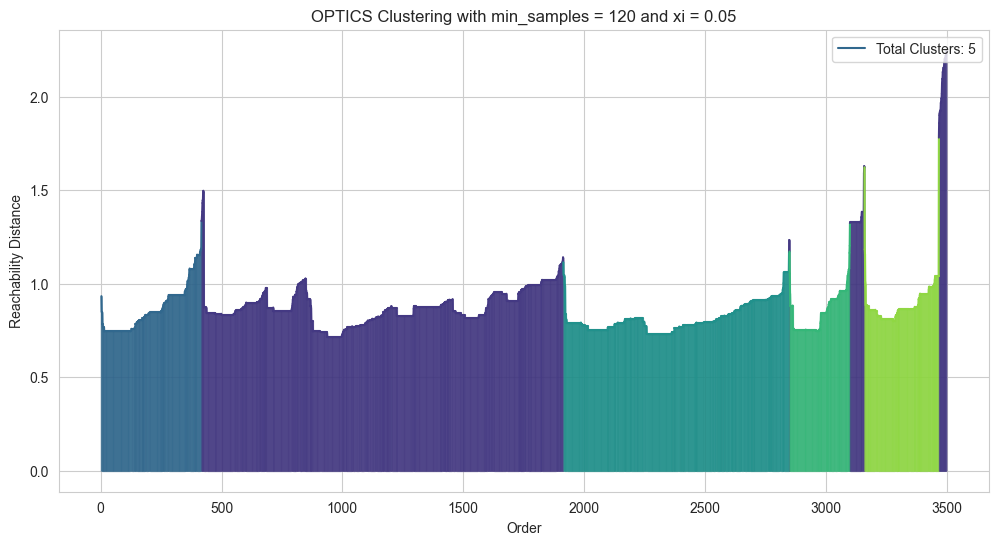

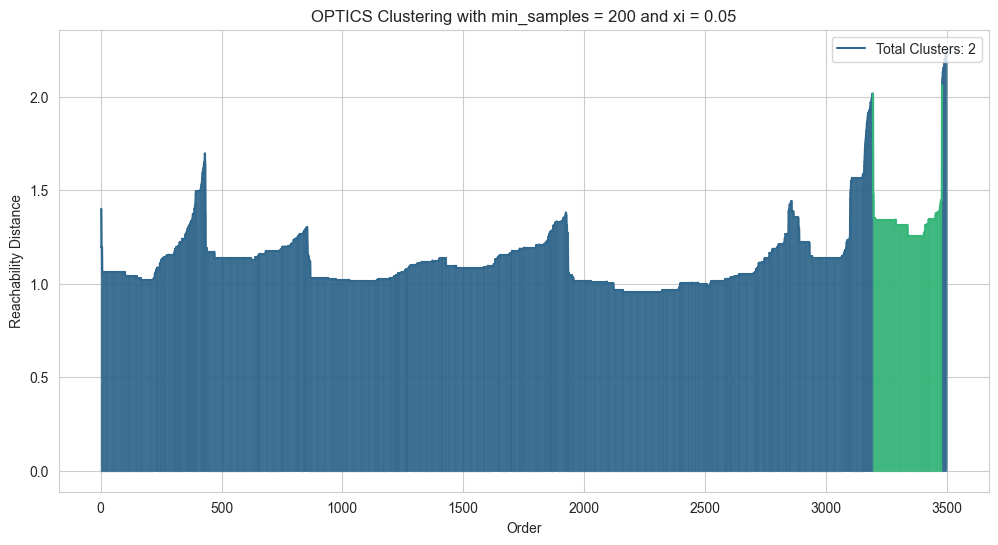

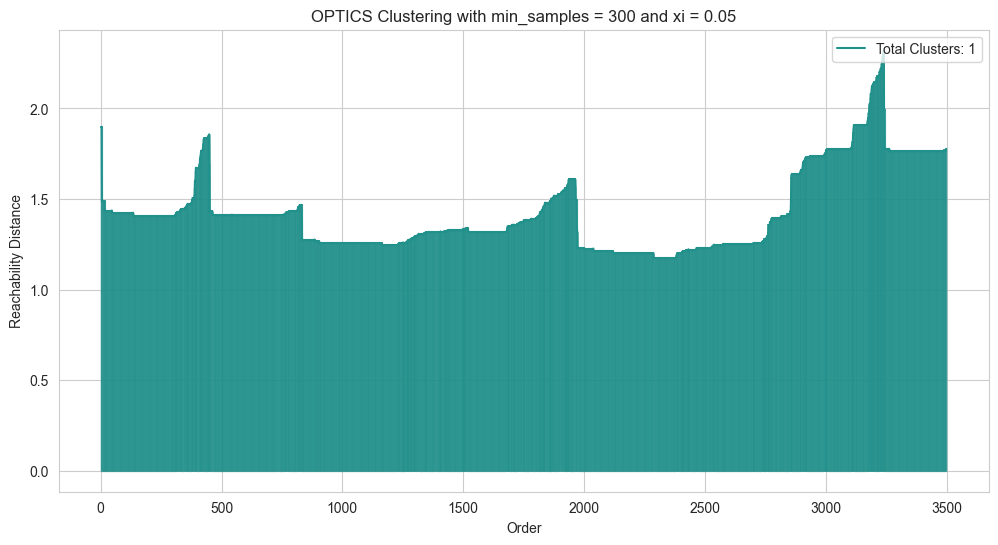

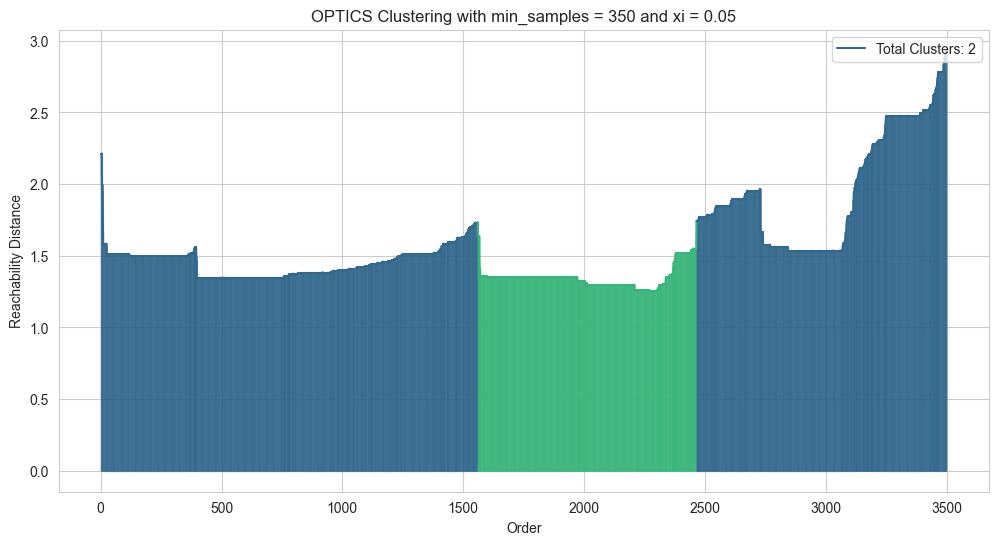

In [14]:
umap_sample_sizes = [5, 80, 120, 200, 300, 350]
umap_optics = [optics_clustering_with_reachability(df_umap, min_samples = sample) for sample in umap_sample_sizes]

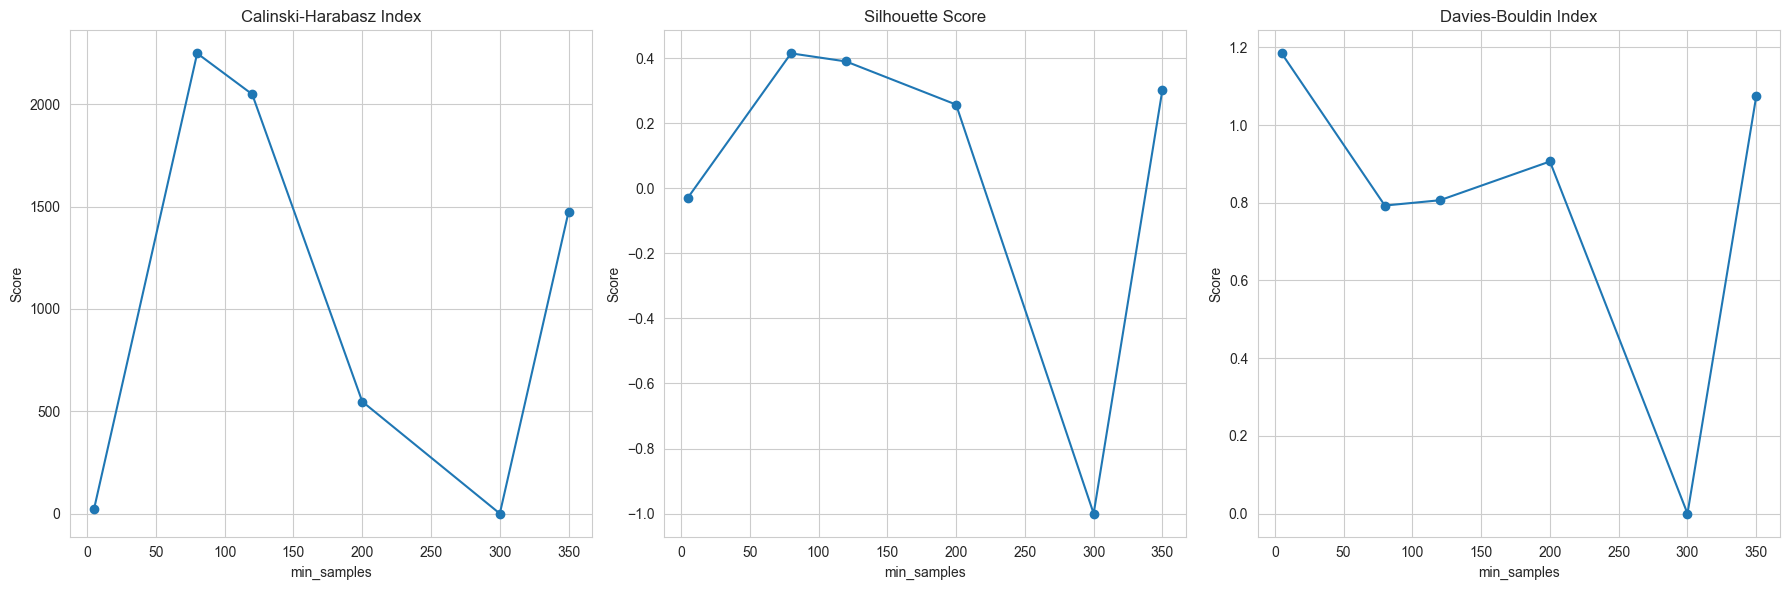

In [15]:
plot_optics_metrics(df_umap, umap_optics, umap_sample_sizes)

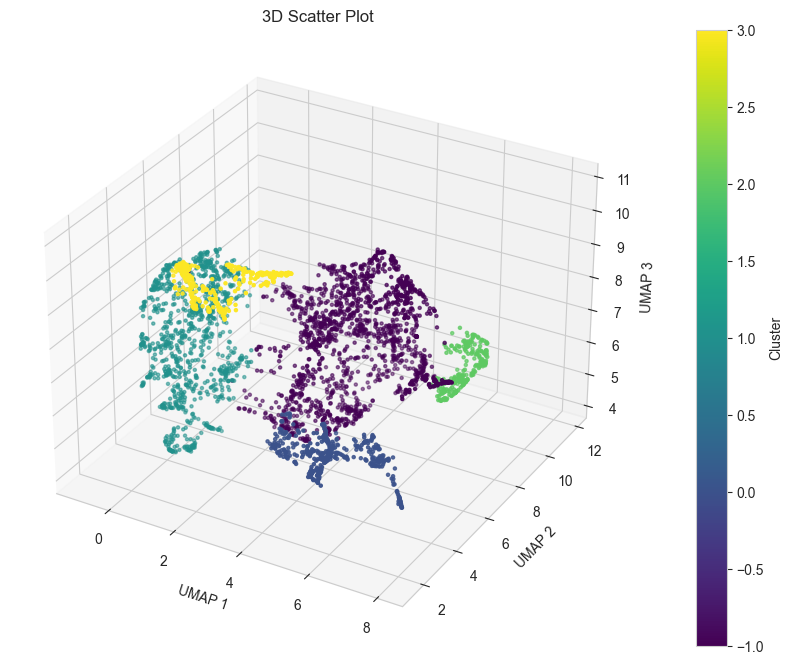

In [16]:
visualise_optics_clusters(df_umap, umap_optics[2].labels_, 'UMAP', s = 5)

## 2.0 Model Fine-Tuning
It can be seen that the OPTICS model performs quite poor on the scaled dataset. This is due to the fact that the dataset is not well-suited for clustering. The dataset is not dense enough to form clusters. This is evident from the reachability distances plot, where the distances are quite high and the clusters are not well-defined.

It is also observed that the dimensionally reduced datasets (specifically UMAP) perform better than the scaled dataset. This is due to the fact that the dimensionally reduced datasets are dense and have better-defined clusters.

Hence, fine-tuning will be focusing on the UMAP dataset with different xi values.

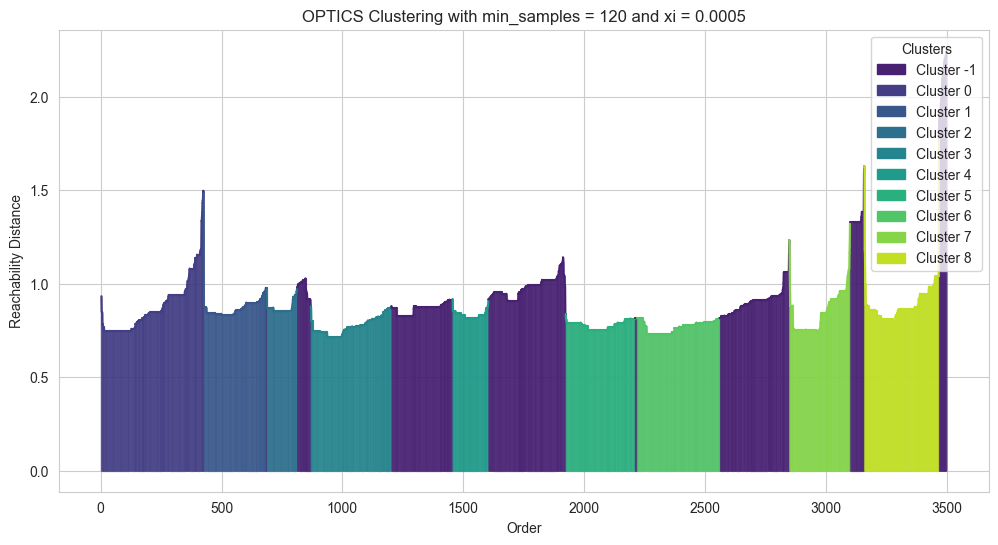

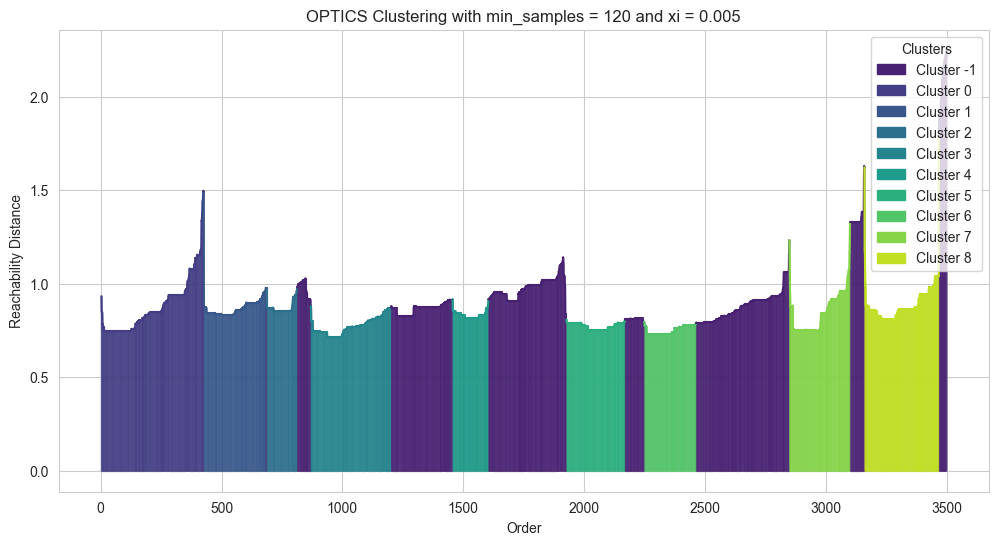

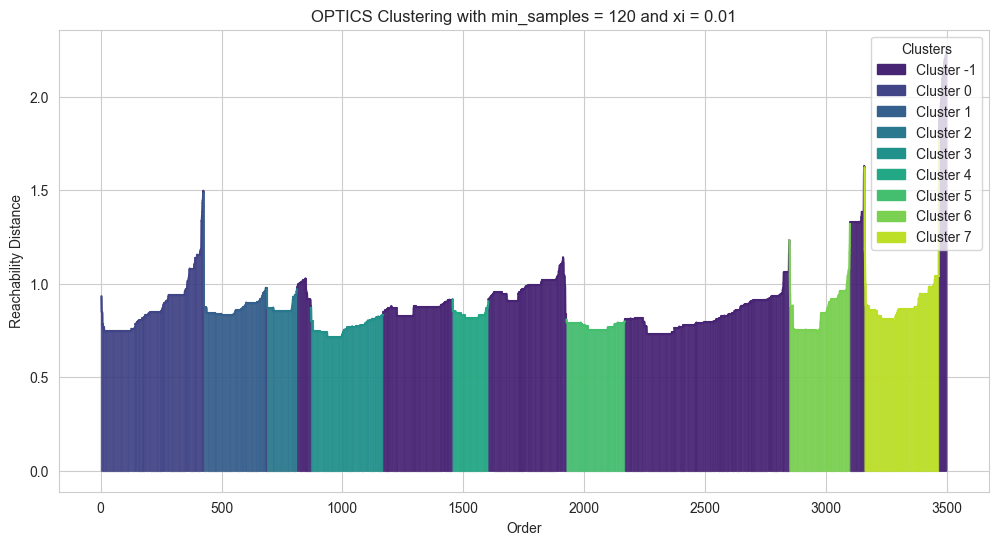

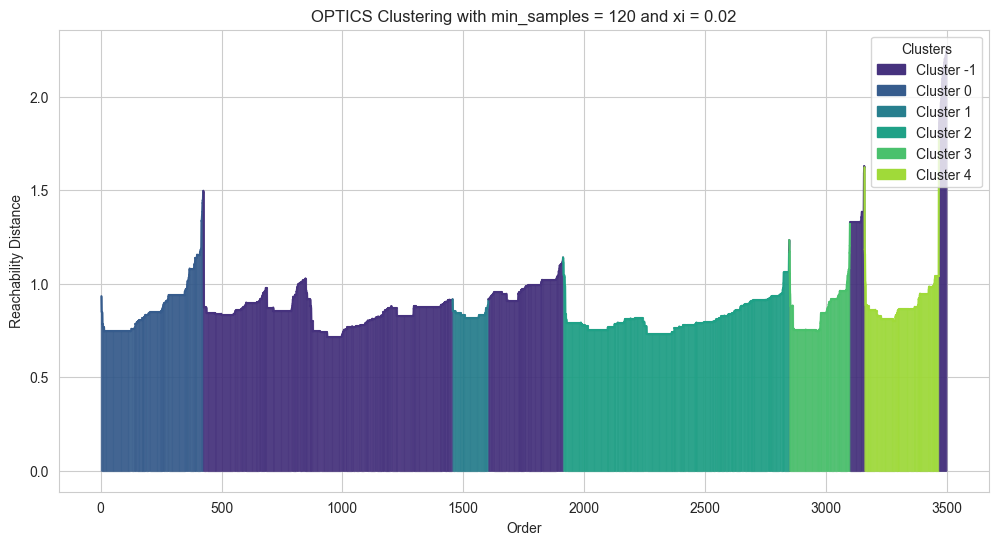

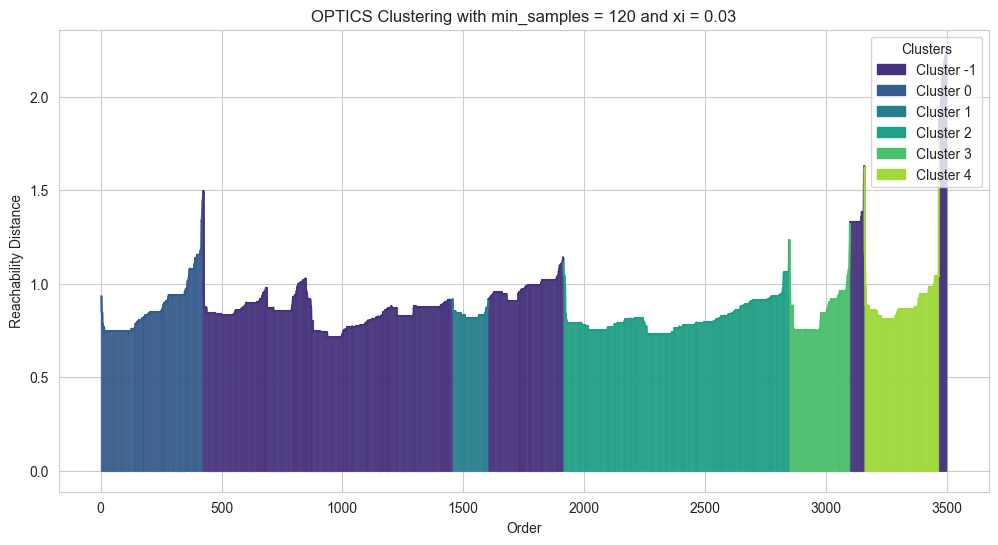

In [17]:
umap_120_xis = [0.0005, 0.005, 0.01, 0.02, 0.03]
umap_120_fine_tune_optics = [optics_clustering_with_reachability(df_umap, min_samples = 120, xi = xi, show_number_of_clusters = False) for xi in umap_120_xis]

# 0.03

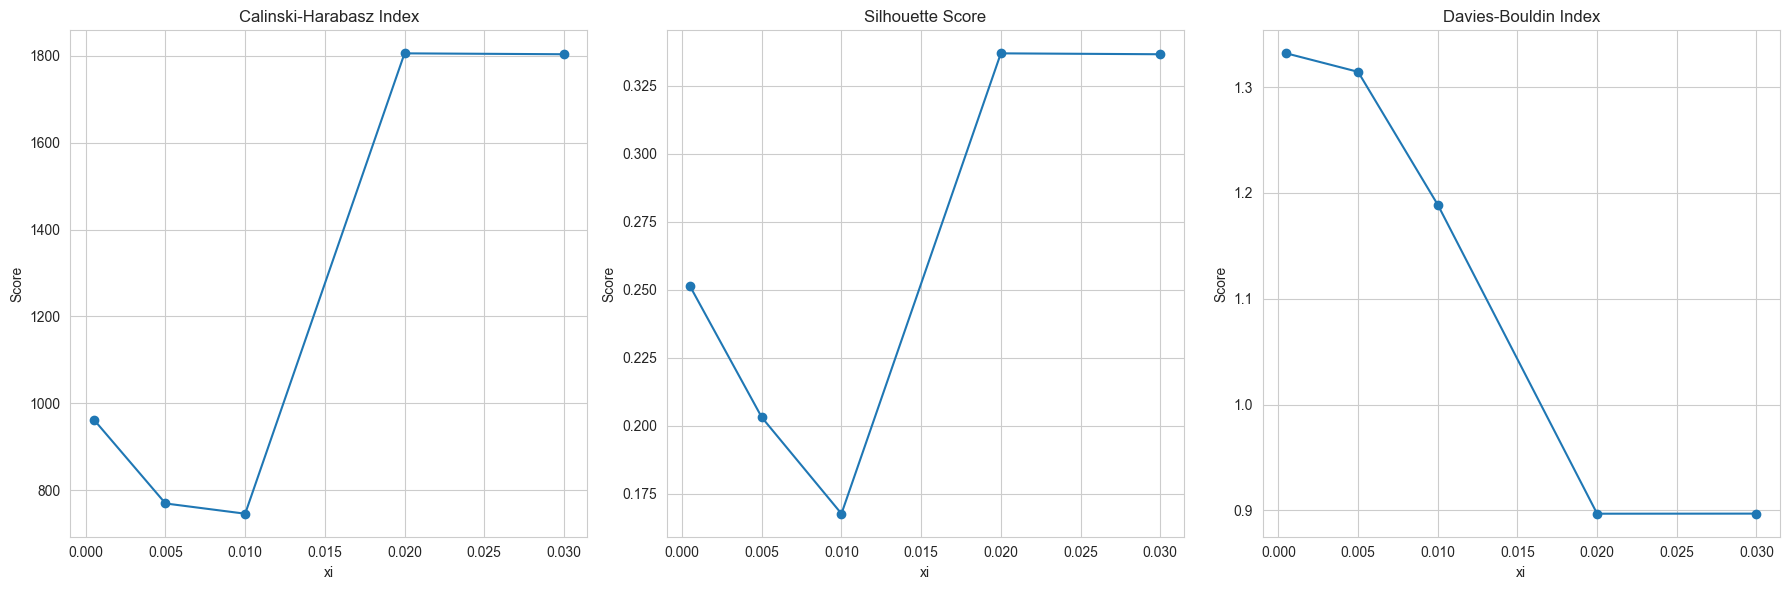

In [18]:
plot_optics_metrics(df_umap, umap_120_fine_tune_optics, umap_120_xis, 'xi')

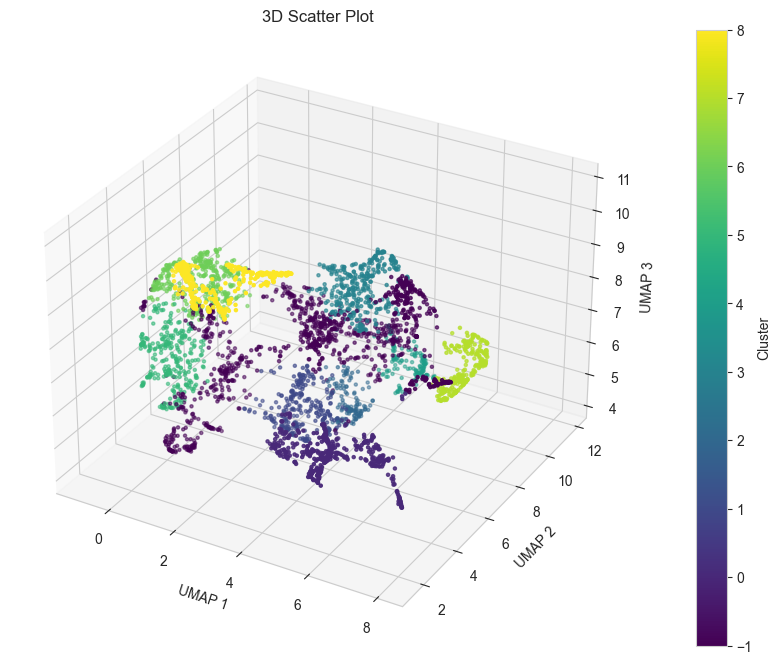

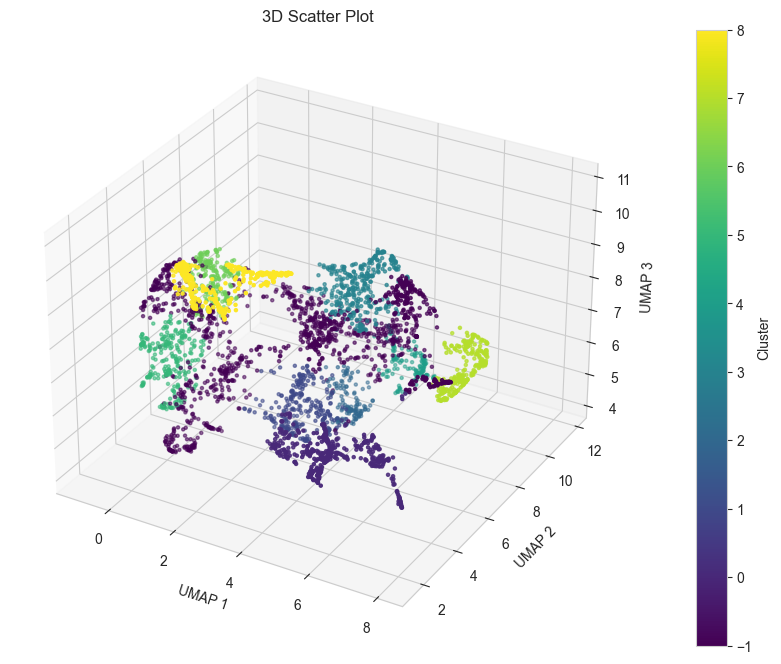

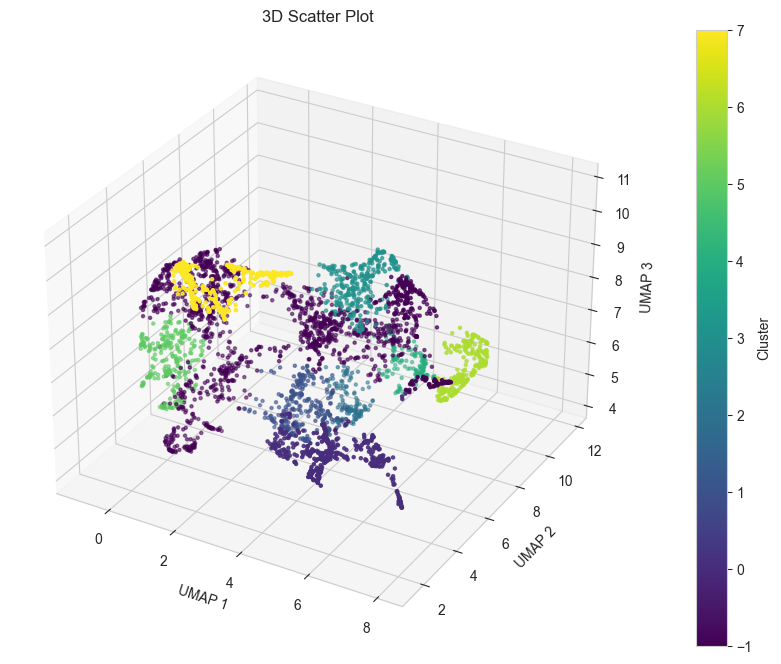

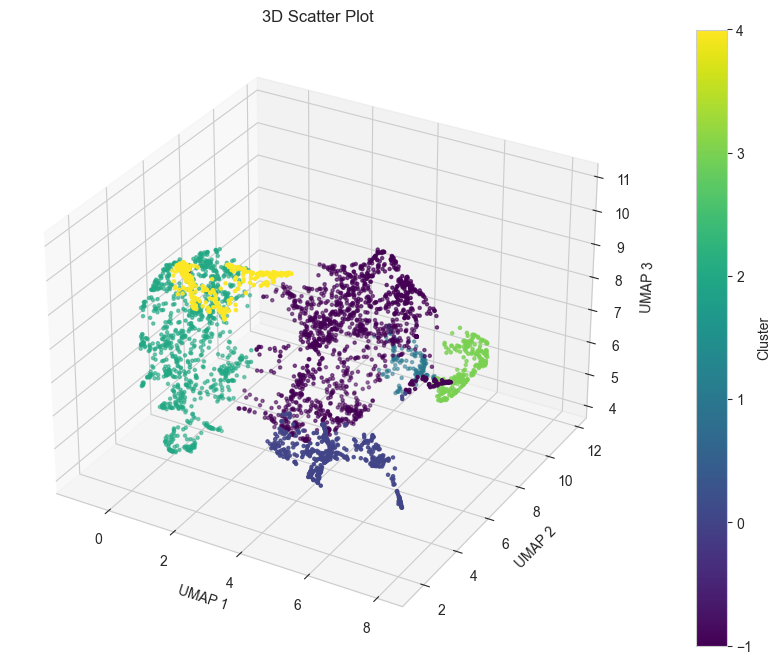

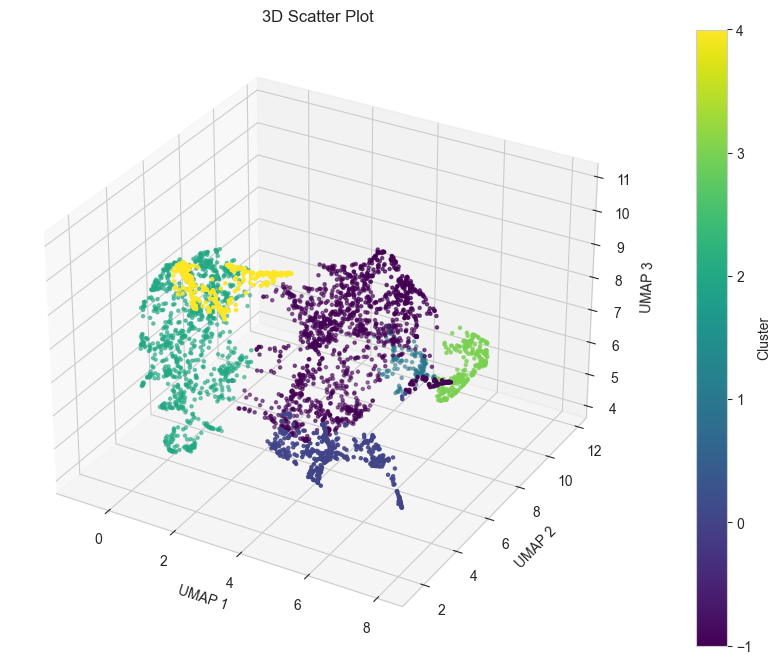

[None, None, None, None, None]

In [19]:
[visualise_optics_clusters(df_umap, model.labels_, 'UMAP', s = 5) for model in umap_120_fine_tune_optics]

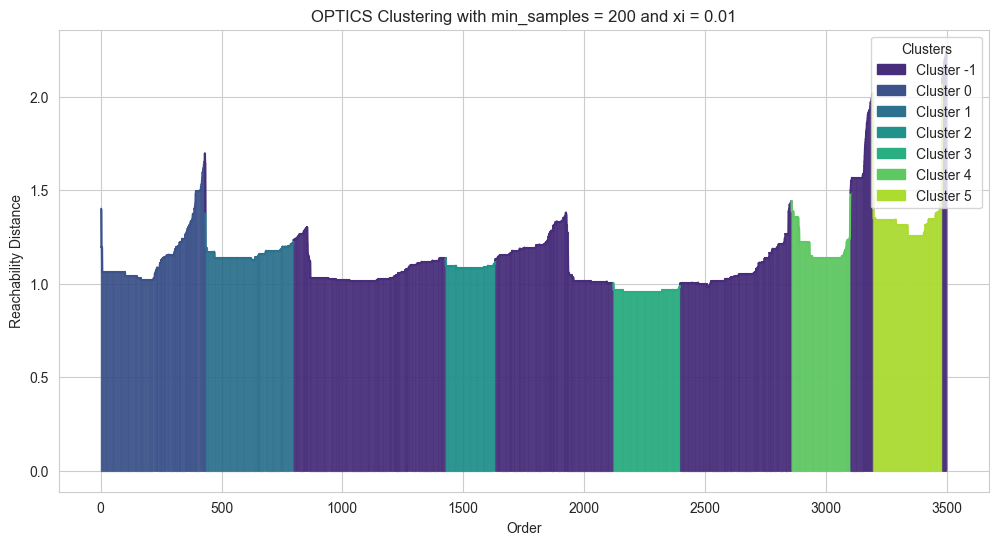

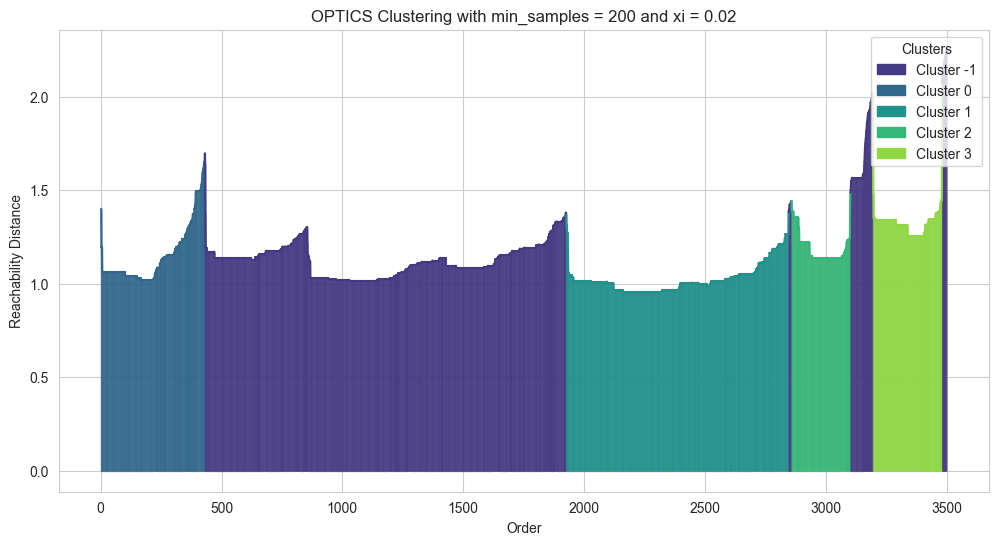

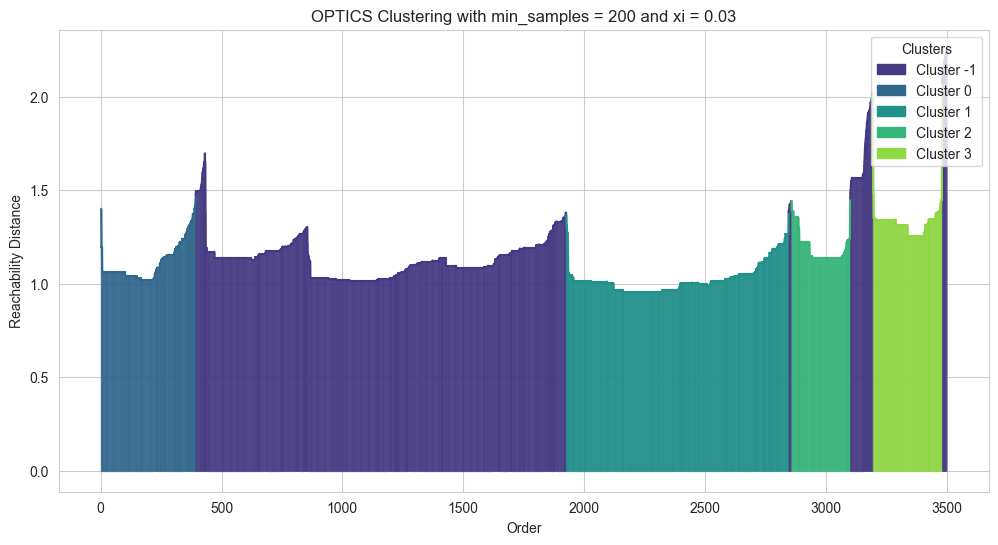

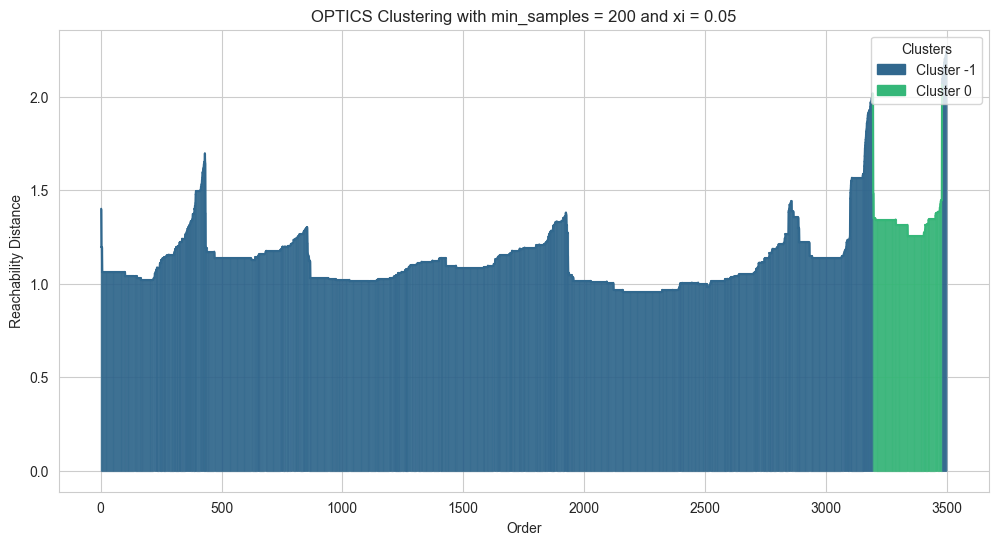

In [20]:
umap_200_xis = [0.01, 0.02, 0.03, 0.05]
umap_200_fine_tune_optics = [optics_clustering_with_reachability(df_umap, min_samples = 200, xi = xi, show_number_of_clusters = False) for xi in umap_200_xis]

# 0.02

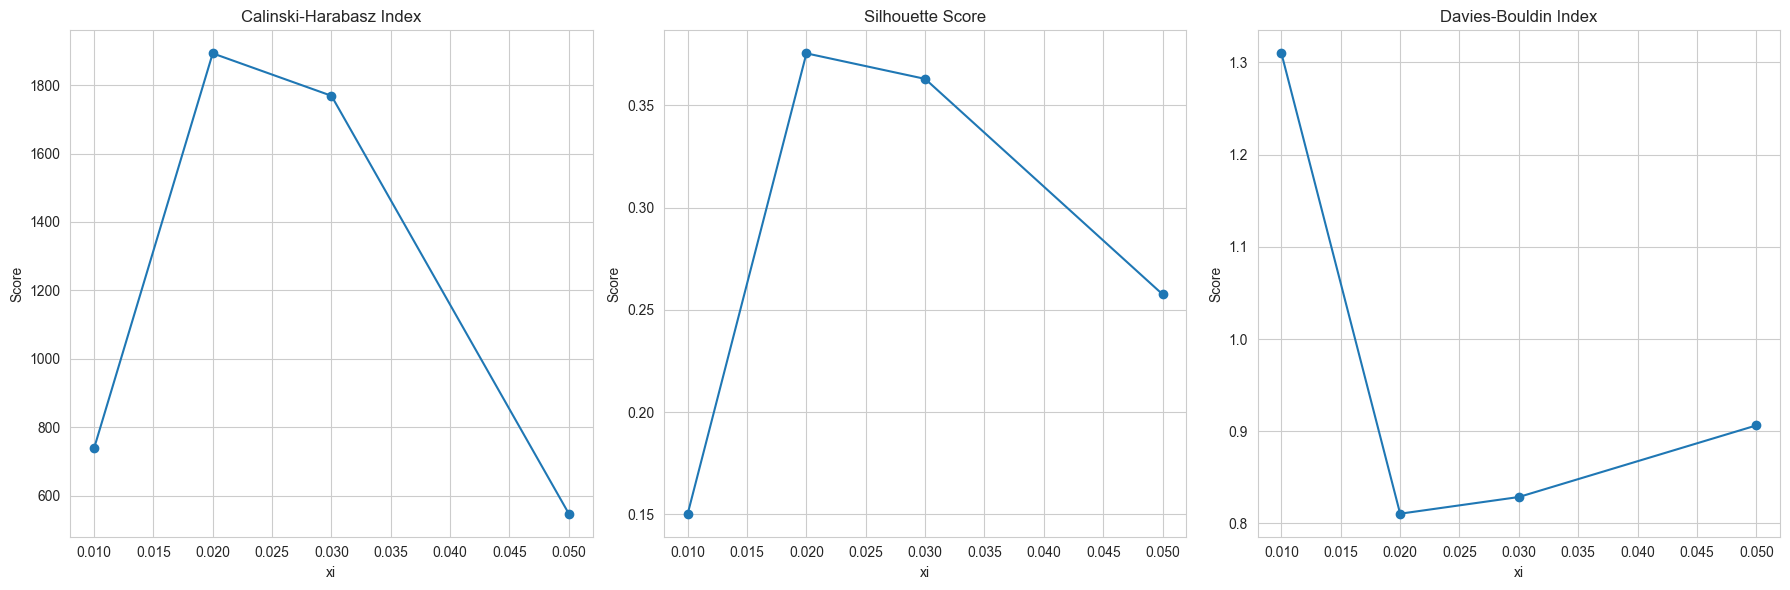

In [21]:
plot_optics_metrics(df_umap, umap_200_fine_tune_optics, umap_200_xis, 'xi')

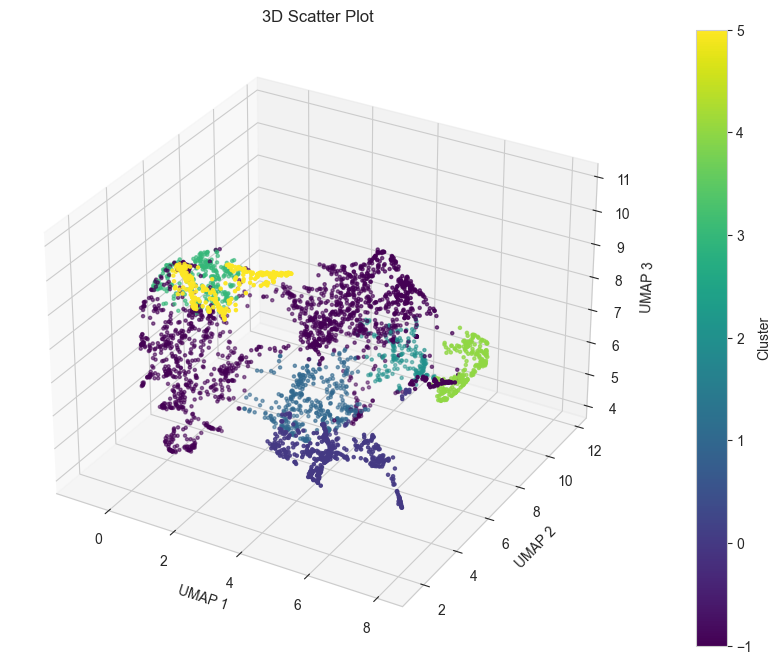

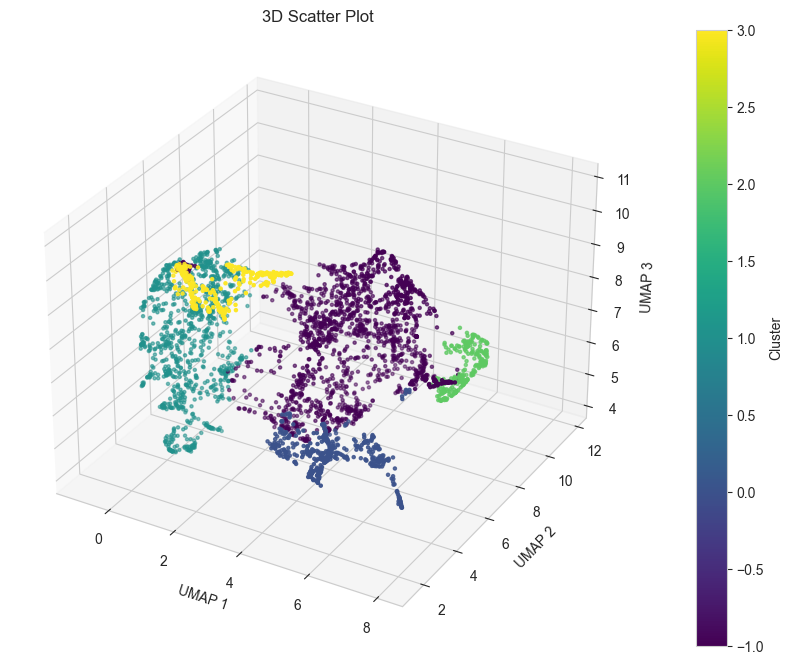

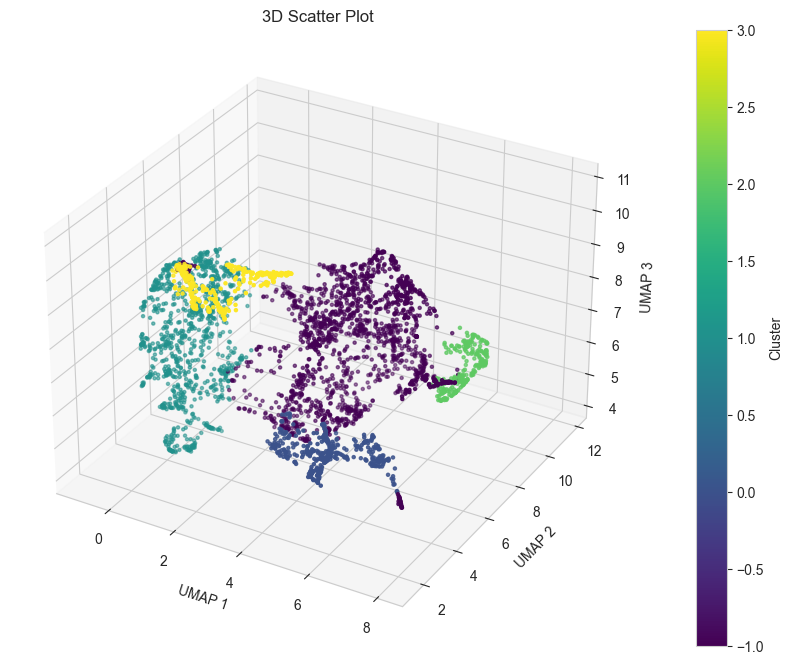

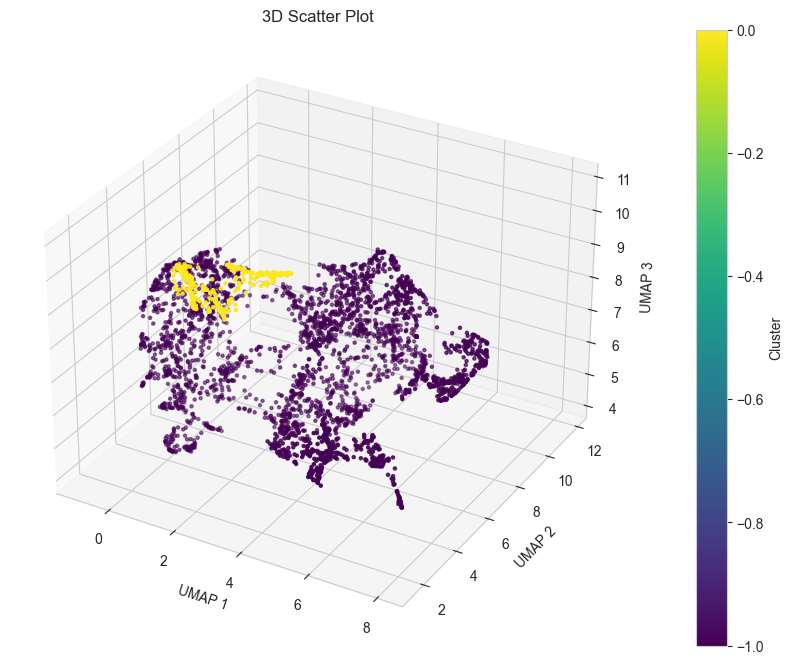

[None, None, None, None]

In [22]:
[visualise_optics_clusters(df_umap, model.labels_, 'UMAP', s = 5) for model in umap_200_fine_tune_optics]

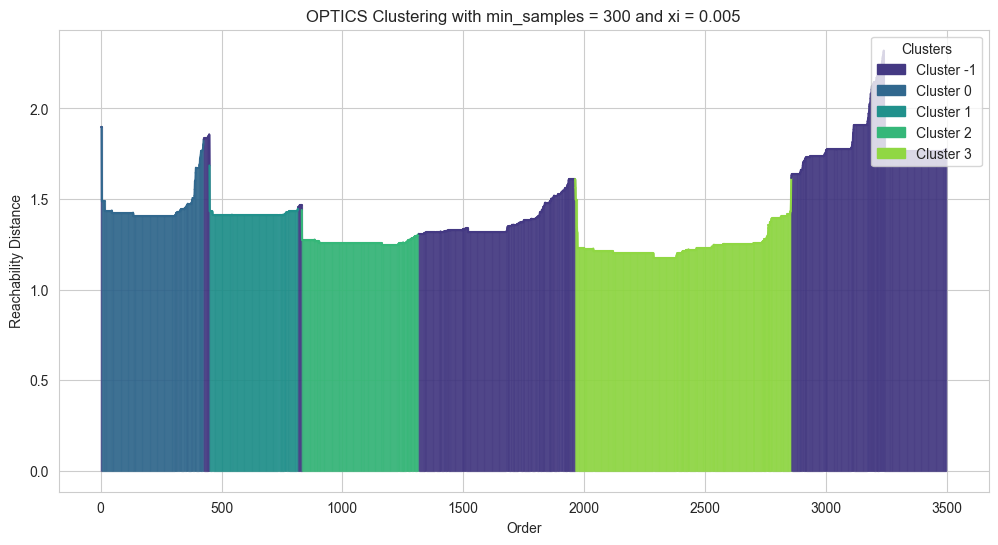

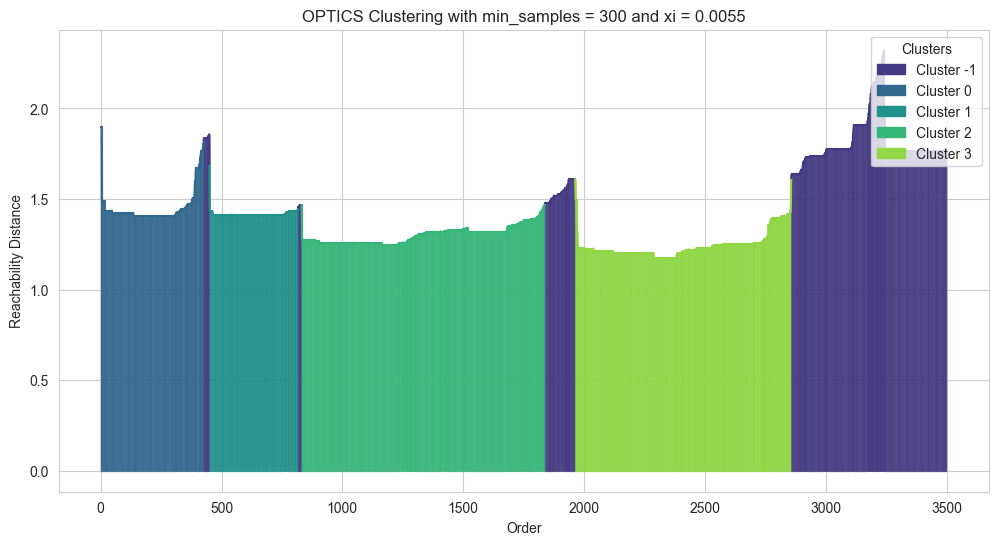

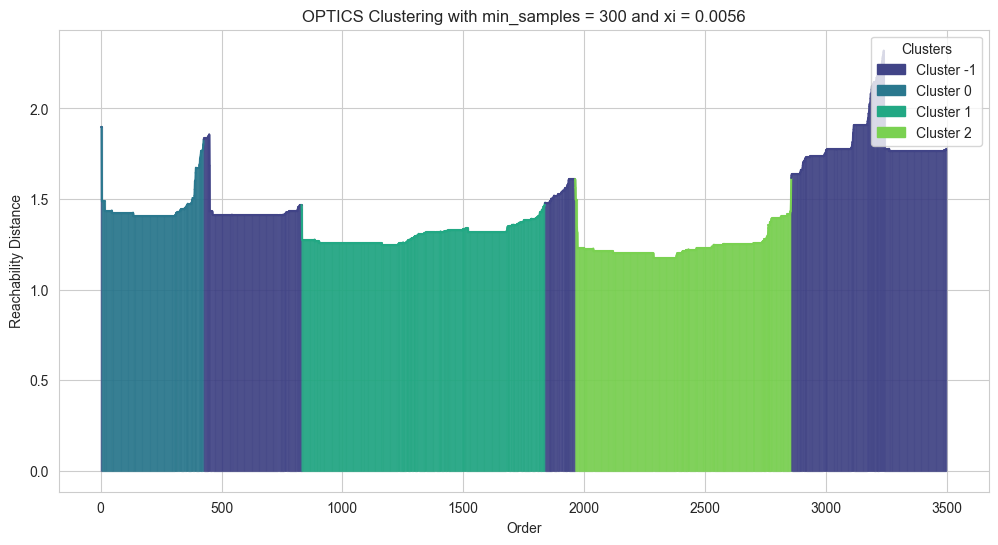

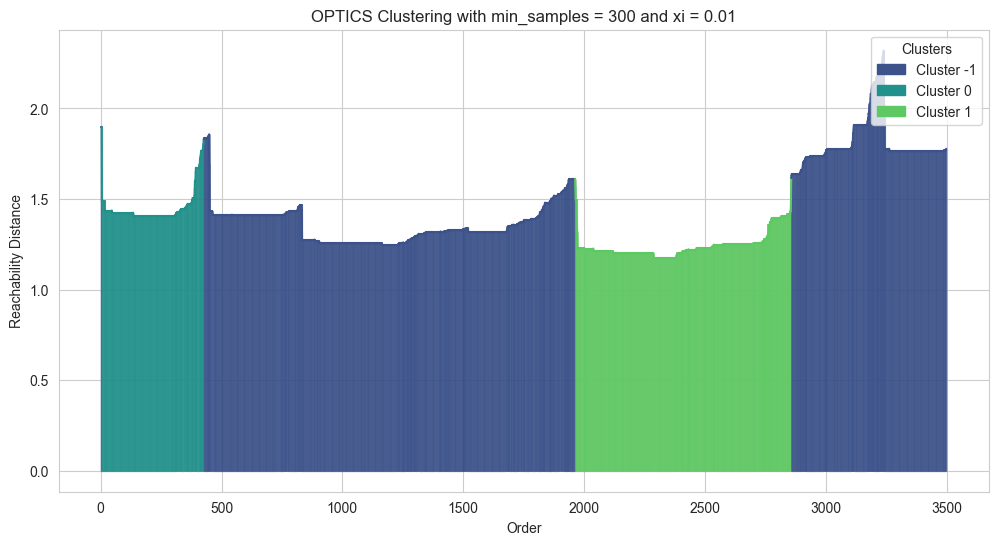

In [23]:
umap_300_xis = [0.005, 0.0055, 0.0056, 0.01]
umap_300_fine_tune_optics = [optics_clustering_with_reachability(df_umap, min_samples = 300, xi = xi, show_number_of_clusters = False) for xi in umap_300_xis]

# 0.0055

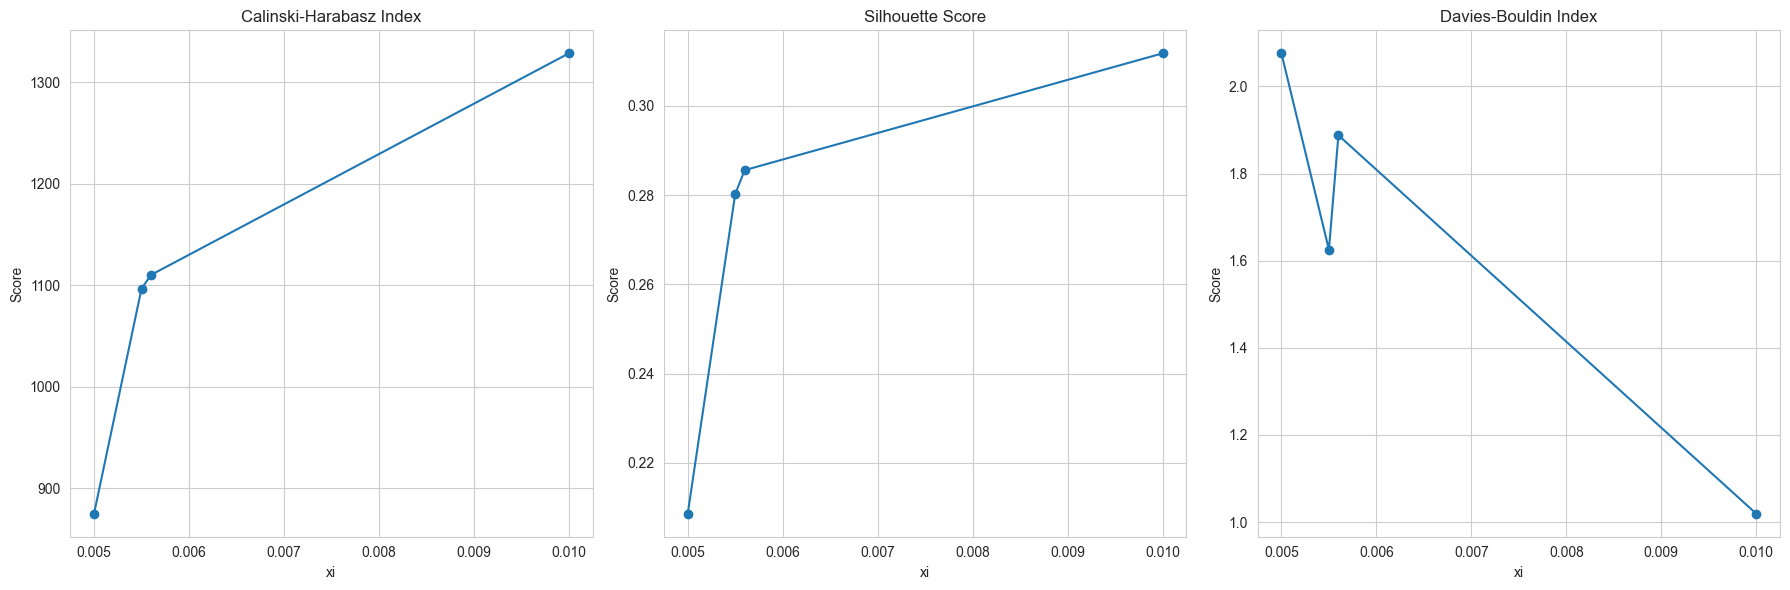

In [24]:
plot_optics_metrics(df_umap, umap_300_fine_tune_optics, umap_300_xis, 'xi')

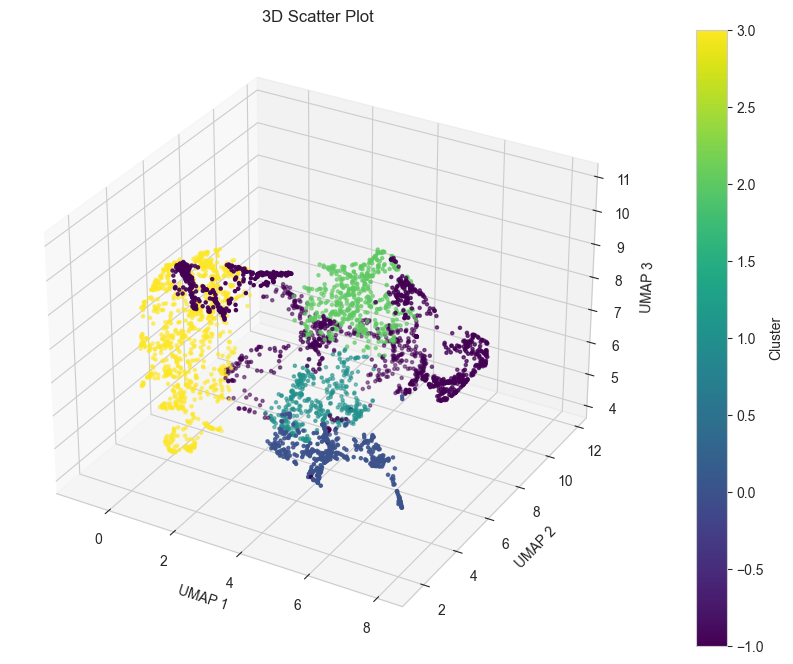

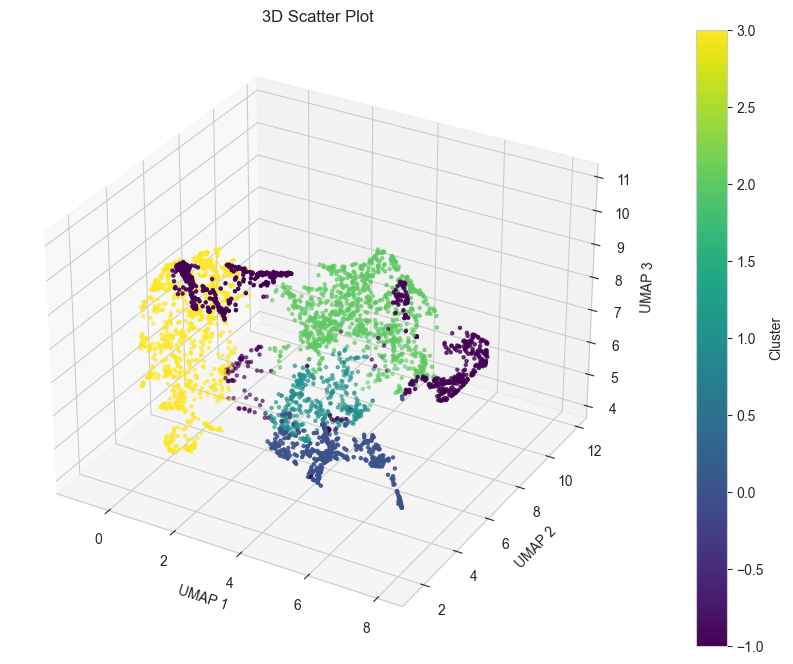

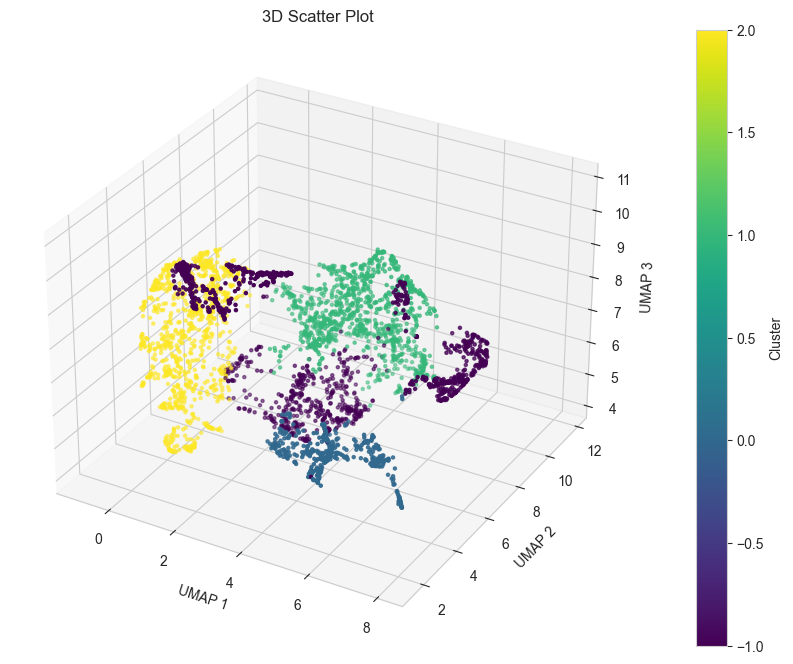

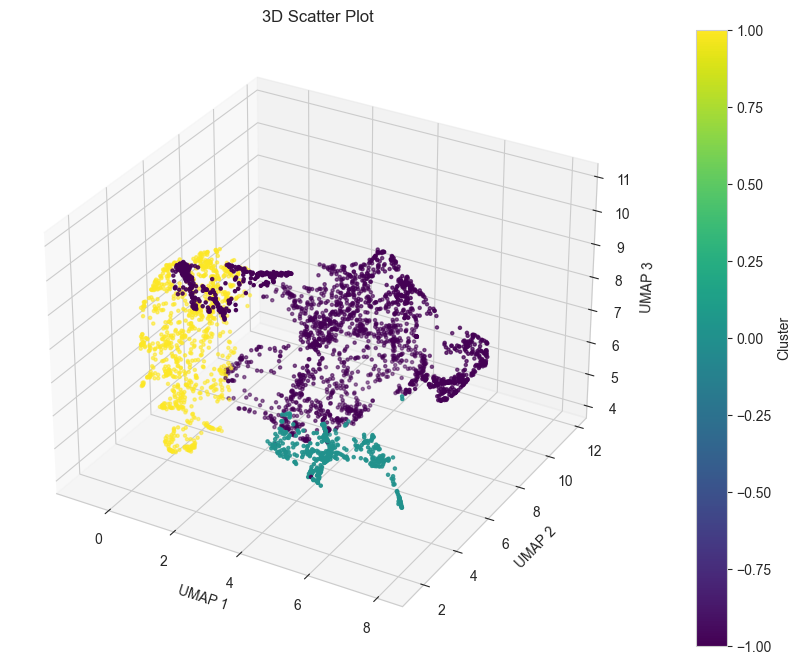

[None, None, None, None]

In [25]:
[visualise_optics_clusters(df_umap, model.labels_, 'UMAP', s = 5) for model in umap_300_fine_tune_optics]

## 2.1 GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV

# Custom scoring function for Calinski-Harabasz Index
def ch_scorer(clustering_model, X, y_true = None):
    labels = clustering_model.fit(X).labels_
    if len(set(labels)) > 1:
        return calinski_harabasz_score(X, labels)
    else:
        return -1  # Return a low score if only one cluster is found

# Define the parameter grid
param_grid = {
    'min_samples': [120, 200, 300],
    'xi': list(set(umap_120_xis).union(set(umap_200_xis)).union(set(umap_300_xis)))
}

# Initialize the OPTICS model
optics_test = OPTICS()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator = optics_test, param_grid = param_grid, scoring = ch_scorer, n_jobs = -1, cv = 5)

# Fit GridSearchCV to the data
grid_search.fit(df_umap)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CH Score:", best_score)

Best Parameters: {'min_samples': 120, 'xi': 0.0005}
Best CH Score: 276.28851409095046


In [30]:
from sklearn.model_selection import GridSearchCV

# Custom scoring function for Calinski-Harabasz Index
def silhouette_scorer(clustering_model, X, y_true = None):
    labels = clustering_model.fit(X).labels_
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Return a low score if only one cluster is found

# Define the parameter grid
param_grid = {
    'min_samples': [120, 200, 300],
    'xi': list(set(umap_120_xis).union(set(umap_200_xis)).union(set(umap_300_xis)))
}

# Initialize the OPTICS model
optics_test = OPTICS()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator = optics_test, param_grid = param_grid, scoring = silhouette_scorer, n_jobs = -1, cv = 5)

# Fit GridSearchCV to the data
grid_search.fit(df_umap)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Best Parameters: {'min_samples': 120, 'xi': 0.0005}
Best Silhouette Score: 0.31341148043115147


In [31]:
from sklearn.model_selection import GridSearchCV

# Custom scoring function for Calinski-Harabasz Index
def davies_bouldin_scorer(clustering_model, X, y_true = None):
    labels = clustering_model.fit(X).labels_
    if len(set(labels)) > 1:
        return -1 * davies_bouldin_score(X, labels)
    else:
        return -1000  # Return a low score if only one cluster is found

# Define the parameter grid
param_grid = {
    'min_samples': [120, 200, 300],
    'xi': list(set(umap_120_xis).union(set(umap_200_xis)).union(set(umap_300_xis)))
}

# Initialize the OPTICS model
optics_test = OPTICS()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator = optics_test, param_grid = param_grid, scoring = davies_bouldin_scorer, n_jobs = -1, cv = 5)

# Fit GridSearchCV to the data
grid_search.fit(df_umap)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CH Score:", -1 * best_score)

Best Parameters: {'min_samples': 120, 'xi': 0.02}
Best CH Score: 1.2878665039375297
